# MBRSET Patient-Level Evaluation

This notebook performs **patient-level** diabetic retinopathy classification on MBRSET.

## Workflow
1. Load all embeddings (one CSV per embedding model)
2. Create a **single 80/20 patient-level train/test split** (reused for all embeddings)
3. Train **LightGBM** and **MLP** for:
   - Binary DR tasks (any DR, referable)
   - 3-class DR task
4. Evaluate on **patient-level** (aggregate predictions per patient)
5. Generate:
   - Classification reports
   - Confusion matrices
   - ROC curves (binary tasks)
   - Training dynamics (train vs validation loss)

## 1. Setup and Imports

In [16]:
import os
import copy
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    log_loss,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import src.retina_evaluation as reval
from src.retina_benchmark import list_embeddings_csvs
from src.retina_embeddings_dataset import load_retina_embeddings_dataset

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use("seaborn-v0_8-whitegrid")

print("Imports complete.")

Imports complete.


## 2. Configuration

In [17]:
# Paths and dataset
PROJECT_ROOT = Path.cwd()
DATASET_NAME = "mbrset"
VIEW = "macula"

# Split configuration
RANDOM_SEED = 42
TEST_FRAC = 0.2  # 80/20 split

# Task definitions
BINARY_TASKS = ["task_any_dr", "task_referable"]
BINARY_TASK_MAP = {
    "task_any_dr": "task_any_diab_retino",
    "task_referable": "task_ref_macular",
}

# Model hyperparameters (task-specific regularization)
CPU_COUNT = os.cpu_count() or 1

# Dimensionality Reduction
USE_PCA = True
PCA_N_COMPONENTS = 30  # Reduce huge embedding dimensions to 30 to combat overfitting

# ─── WEIGHTING + THRESHOLDING (PRIMARY KNOBS) ───
## Weighting modes:
##   - "manual": use manual class weight ratio (e.g., {0:1, 1:3})
##   - "balanced": compute weights dynamically via sklearn `compute_class_weight('balanced', ...)`
##   - "none": no reweighting (uniform)

WEIGHTING_CONFIG = {
    "binary": {
        "mode": "manual",
        "manual": {0: 1.0, 1: 3.0},
        "damping_gamma": 1.0,  # <1.0 softens extremes; 1.0 leaves weights unchanged
    },
    "multiclass": {
        "mode": "balanced",
        "manual": None,
        "damping_gamma": 1.0,
    },
}

# Compare two presets for binary tasks (requested):
#   1) {0:1, 1:3} + F1 thresholding
#   2) {0:1, 1:2} + Youden thresholding
# If recall stays low, increase minority ratio gradually (1:4, 1:5) and optionally soften with damping_gamma=0.7–0.8.
RUN_BINARY_PRESETS = True
BINARY_PRESETS = [
    {
        "name": "w13_f1",
        "binary_weighting": {"mode": "manual", "manual": {0: 1.0, 1: 3.0}, "damping_gamma": 1.0},
        "threshold_method": "f1",
    },
    {
        "name": "w12_youden",
        "binary_weighting": {"mode": "manual", "manual": {0: 1.0, 1: 2.0}, "damping_gamma": 1.0},
        "threshold_method": "youden",
    },
    # Examples to try next (disabled by default):
    # {"name": "w14_f1_g08", "binary_weighting": {"mode": "manual", "manual": {0:1.0,1:4.0}, "damping_gamma": 0.8}, "threshold_method": "f1"},
    # {"name": "w15_f1_g08", "binary_weighting": {"mode": "manual", "manual": {0:1.0,1:5.0}, "damping_gamma": 0.8}, "threshold_method": "f1"},
]

# For LightGBM, apply weights via model `class_weight` or via `sample_weight` in `.fit()`
LGBM_WEIGHT_APPLICATION = "class_weight"  # "class_weight" | "sample_weight"

# For MLPClassifier, we apply training weights via `sample_weight` when supported
MLP_USE_SAMPLE_WEIGHT = True

# Default threshold selection on internal validation set (binary tasks only)
THRESHOLD_METHOD = "f1"  # "youden" | "f1"
THRESHOLD_GRID_SIZE = 99

# ─── BASE CONFIGS (defaults — overridden per embedding below) ───

MLP_CONFIG_BINARY = {
    "hidden_layer_sizes": (32,),
    "alpha": 0.45,
    "learning_rate_init": 0.0008,
    "batch_size": 32,
    "max_epochs": 400,
    "patience": 35,
    "min_delta": 1e-4,
    "warmup_epochs": 5,
}

MLP_CONFIG_MULTICLASS = {
    "hidden_layer_sizes": (64,),
    "alpha": 0.55,
    "learning_rate_init": 0.0004,
    "batch_size": 32,
    "max_epochs": 400,
    "patience": 40,
    "min_delta": 1e-4,
    "warmup_epochs": 5,
}

LGBM_CONFIG_BINARY = {
    "n_estimators": 2000,
    "num_leaves": 15,
    "min_child_samples": 30,
    "reg_lambda": 4.5,
    "reg_alpha": 1.0,
    "subsample": 0.65,
    "colsample_bytree": 0.65,
    "min_split_gain": 0.03,
    "learning_rate": 0.01,
    "early_stopping_rounds": 300,
    "class_weight": None,  # set dynamically from WEIGHTING_CONFIG / BINARY_PRESETS if LGBM_WEIGHT_APPLICATION='class_weight'
}

LGBM_CONFIG_MULTICLASS = {
    "n_estimators": 2000,
    "num_leaves": 12,
    "min_child_samples": 35,
    "reg_lambda": 3.0,
    "reg_alpha": 0.8,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "min_split_gain": 0.03,
    "learning_rate": 0.01,
    "early_stopping_rounds": 300,
    "class_weight": None,  # set dynamically from WEIGHTING_CONFIG when LGBM_WEIGHT_APPLICATION='class_weight'
}

# ─── PER-EMBEDDING OVERRIDES ───
# Minimal overrides — no aggressive hyperparameter changes
# Focus on sample weight adjustments instead

EMBEDDING_OVERRIDES = {
    "dinov3_convnext_base": {},
    "dinov3_vitb16": {},
    "RETFound_mae_shanghai": {},
    "RETFound_mae_natureCFP": {},
    "RETFound_dinov2_shanghai": {},
    "vit_base": {},
    "convnextv2_base": {},
}


def resolve_config(model_type, task_type, emb_stem):
    """
    Merge base config with per-embedding overrides.
    Returns (config_dict, matched_pattern | None).
    """
    if model_type == "mlp":
        base = MLP_CONFIG_BINARY.copy() if task_type == "binary" else MLP_CONFIG_MULTICLASS.copy()
    else:
        base = LGBM_CONFIG_BINARY.copy() if task_type == "binary" else LGBM_CONFIG_MULTICLASS.copy()

    matched = None
    override_key = f"{model_type}_{task_type}"
    for pattern, overrides in EMBEDDING_OVERRIDES.items():
        if pattern in emb_stem:
            if override_key in overrides and overrides[override_key]:
                base.update(overrides[override_key])
                matched = pattern
            break

    return base, matched


# Output configuration
RESULTS_DIR = PROJECT_ROOT / "results" / "mbrset_patient_eval"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

SHOW_PLOTS = True
SAVE_PLOTS = True

print(f"Dataset: {DATASET_NAME}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Test fraction: {TEST_FRAC}")
print(f"PCA Enabled: {USE_PCA} (components={PCA_N_COMPONENTS})")
print(f"Embedding-specific overrides: {len(EMBEDDING_OVERRIDES)} embeddings configured")
print(f"Default weighting (binary): {WEIGHTING_CONFIG['binary']}")
print(f"Default weighting (multiclass): {WEIGHTING_CONFIG['multiclass']}")
print(f"Binary presets enabled: {RUN_BINARY_PRESETS} (n={len(BINARY_PRESETS)})")
print(f"LGBM weight application: {LGBM_WEIGHT_APPLICATION}")
print(f"Default threshold method: {THRESHOLD_METHOD} (grid={THRESHOLD_GRID_SIZE})")

Dataset: mbrset
Results directory: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\mbrset_patient_eval
Random seed: 42
Test fraction: 0.2
PCA Enabled: True (components=30)
Embedding-specific overrides: 7 embeddings configured
Default weighting (binary): {'mode': 'manual', 'manual': {0: 1.0, 1: 3.0}, 'damping_gamma': 1.0}
Default weighting (multiclass): {'mode': 'balanced', 'manual': None, 'damping_gamma': 1.0}
Binary presets enabled: True (n=2)
LGBM weight application: class_weight
Default threshold method: f1 (grid=99)


## 3. Load Embeddings and Create Patient-Level Split

In [18]:
# Get paths
embed_dir = PROJECT_ROOT / "data" / f"{DATASET_NAME}_embeddings"
labels_path = embed_dir / f"{DATASET_NAME}_labels" / f"labels_{DATASET_NAME}.csv"

# List all embedding files
embedding_files = list_embeddings_csvs(embed_dir)
if not embedding_files:
    raise FileNotFoundError(f"No embedding CSV files found under {embed_dir}")

print(f"Found {len(embedding_files)} embedding files:")
for i, emb in enumerate(embedding_files):
    print(f"  {i}: {emb.name}")

# Load first embedding to create the split
base_ds = load_retina_embeddings_dataset(
    dataset=DATASET_NAME,
    embeddings_csv_path=embedding_files[0],
    labels_csv_path=labels_path,
    view=VIEW,
)

# Create patient-level split (stratified by task_any_dr)
split = reval.make_patient_split(
    df=base_ds.df,
    group_col="patient_id",
    label_col="task_any_dr",
    val_frac=TEST_FRAC,
    seed=RANDOM_SEED,
)

print(f"\nPatient split:")
print(f"  Train patients: {len(split.train_patient_ids)}")
print(f"  Test patients: {len(split.val_patient_ids)}")
print(f"  Total: {len(split.train_patient_ids) + len(split.val_patient_ids)}")

# Save split for reproducibility
split_info = pd.DataFrame({
    "patient_id": list(split.train_patient_ids) + list(split.val_patient_ids),
    "split": ["train"] * len(split.train_patient_ids) + ["test"] * len(split.val_patient_ids),
})
split_info.to_csv(RESULTS_DIR / "patient_split.csv", index=False)
print(f"\nSaved split to: {RESULTS_DIR / 'patient_split.csv'}")

Found 7 embedding files:
  0: Embeddings_convnextv2_base_mbrset.csv
  1: Embeddings_mbrset_dinov3_convnext_base.csv
  2: Embeddings_mbrset_dinov3_vitb16.csv
  3: Embeddings_mbrset_RETFound_dinov2_shanghai.csv
  4: Embeddings_mbrset_RETFound_mae_natureCFP.csv
  5: Embeddings_mbrset_RETFound_mae_shanghai.csv
  6: Embeddings_vit_base_mbrset.csv

Patient split:
  Train patients: 1032
  Test patients: 259
  Total: 1291

Saved split to: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\mbrset_patient_eval\patient_split.csv


## 4. Helper Functions for Patient-Level Aggregation

In [19]:
from sklearn.utils.class_weight import compute_class_weight


def aggregate_patient_predictions(df, group_col="patient_id"):
    """
    Aggregate image-level predictions to patient-level by taking the majority vote
    for class labels and averaging probabilities.
    """
    patient_groups = []
    
    for patient_id, group in df.groupby(group_col):
        # Majority vote for prediction
        y_pred_patient = group["y_pred"].mode()[0] if len(group["y_pred"].mode()) > 0 else group["y_pred"].iloc[0]
        
        # Average probability
        y_proba_patient = group["y_proba"].mean()
        
        # True label (should be same for all images of a patient)
        y_true_patient = group["y_true"].mode()[0] if len(group["y_true"].mode()) > 0 else group["y_true"].iloc[0]
        
        patient_groups.append({
            "patient_id": patient_id,
            "y_true": y_true_patient,
            "y_pred": y_pred_patient,
            "y_proba": y_proba_patient,
            "n_images": len(group),
        })
    
    return pd.DataFrame(patient_groups)


def compute_class_weight_mapping(y, mode="balanced", manual_class_weight=None, damping_gamma=1.0):
    """
    Return a {class_label: weight} mapping.

    mode:
      - 'manual': use manual_class_weight (missing classes default to 1.0)
      - 'balanced': compute dynamic balanced weights from y
      - 'none': uniform weights

    damping_gamma < 1.0 softens extremes by applying w := w**damping_gamma.
    """
    y = np.asarray(y)
    classes = np.unique(y)
    if classes.size == 0:
        return {}

    if mode == "none":
        mapping = {int(c): 1.0 for c in classes}
    elif mode == "manual":
        manual_class_weight = manual_class_weight or {}
        mapping = {int(c): float(manual_class_weight.get(int(c), 1.0)) for c in classes}
    elif mode == "balanced":
        w = compute_class_weight(class_weight="balanced", classes=classes, y=y)
        mapping = {int(c): float(wi) for c, wi in zip(classes, w)}
    else:
        raise ValueError(f"Unknown weighting mode: {mode}")

    if damping_gamma is not None and float(damping_gamma) != 1.0:
        gamma = float(damping_gamma)
        mapping = {c: float(w ** gamma) for c, w in mapping.items()}

    return mapping


def compute_sample_weights(y, class_weight_mapping, normalize=True):
    """
    Convert a {class: weight} mapping to per-sample weights.
    If normalize=True, scale weights to mean=1.0 for stability.
    """
    y = np.asarray(y)
    if y.size == 0:
        return np.asarray([], dtype=np.float32)

    sw = np.array([class_weight_mapping.get(int(lbl), 1.0) for lbl in y], dtype=np.float32)
    if normalize and sw.size:
        mean_w = float(np.mean(sw))
        if mean_w > 0:
            sw = sw / mean_w
    return sw


def safe_fit_with_optional_sample_weight(estimator, X, y, sample_weight=None):
    """
    Fit with sample_weight if supported; otherwise fall back to unweighted fit.
    Returns True if sample_weight was used, else False.
    """
    if sample_weight is None:
        estimator.fit(X, y)
        return False
    try:
        estimator.fit(X, y, sample_weight=sample_weight)
        return True
    except TypeError:
        estimator.fit(X, y)
        return False


def find_optimal_threshold(y_true, y_proba, method="youden", grid_size=99):
    """
    Find optimal binary classification threshold using a validation set.

    method:
      - 'youden': maximise (TPR - FPR)
      - 'f1': maximise F1 score on a threshold grid
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    if y_true.size == 0:
        return 0.5

    if method == "youden":
        fpr, tpr, thresholds = roc_curve(y_true, y_proba)
        j_scores = tpr - fpr  # Youden's J
        best_idx = int(np.argmax(j_scores))
        return float(thresholds[best_idx])

    if method == "f1":
        from sklearn.metrics import f1_score
        grid_size = int(grid_size)
        grid_size = max(11, min(grid_size, 1001))
        thresholds = np.linspace(0.01, 0.99, grid_size)
        best_t = 0.5
        best_f1 = -1.0
        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            f1 = float(f1_score(y_true, y_pred, zero_division=0))
            if f1 > best_f1:
                best_f1 = f1
                best_t = float(t)
        return best_t

    raise ValueError(f"Unknown threshold method: {method}")


def weighted_log_loss(y_true, y_proba, labels, sample_weight=None):
    """
    Compute log loss with optional sample weights for class-aware evaluation.
    Used during early stopping so the validation metric is sensitive to
    minority-class performance without distorting training data.
    """
    return log_loss(y_true, y_proba, labels=labels, sample_weight=sample_weight)


def plot_confusion_matrix(cm, title, save_path=None, show=True):
    """Plot confusion matrix."""
    cm = np.asarray(cm)
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    im = ax.imshow(cm, cmap="viridis", interpolation="nearest")
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.tick_params(axis="both", labelsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Count", fontsize=9)

    thresh = cm.max() / 2.0 if cm.size else 0
    for (i, j), val in np.ndenumerate(cm):
        ax.text(
            j, i, f"{val}",
            ha="center", va="center",
            color="white" if val > thresh else "black",
            fontsize=10, fontweight="bold",
        )
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=160, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)


def plot_roc_curve(fpr, tpr, auc, title, save_path=None, show=True):
    """Plot ROC curve."""
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    
    points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=0.0, vmax=1.0)
    lc = LineCollection(segments, cmap="plasma", norm=norm)
    lc.set_array(fpr)
    lc.set_linewidth(2.6)
    ax.add_collection(lc)
    
    ax.plot([0, 1], [0, 1], linestyle="--", color="#666", linewidth=1.2, label="Chance")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"{title}\nAUC = {auc:.3f}", fontsize=11, pad=12)
    ax.set_xlabel("False Positive Rate", fontsize=10)
    ax.set_ylabel("True Positive Rate", fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(loc="lower right", fontsize=9)
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("FPR", fontsize=9)
    cbar.ax.tick_params(labelsize=9)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=160, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)


print("Helper functions defined.")

Helper functions defined.


## 5. Train and Evaluate Models

For each embedding file and task, train LightGBM and MLP with patient-level evaluation.


Embedding 1/7: Embeddings_convnextv2_base_mbrset

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.221 (vs default 0.5)
  Accuracy: 0.815
  Balanced Accuracy: 0.735
  F1 Score: 0.529
  Precision: 0.466
  Recall (Sensitivity): 0.614
  ROC AUC: 0.861

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.915     0.856     0.885       215
           1      0.466     0.614     0.529        44

    accuracy                          0.815       259
   macro avg      0.690     0.735     0.707       259
weighted avg      0.839     0.815     0.824       259



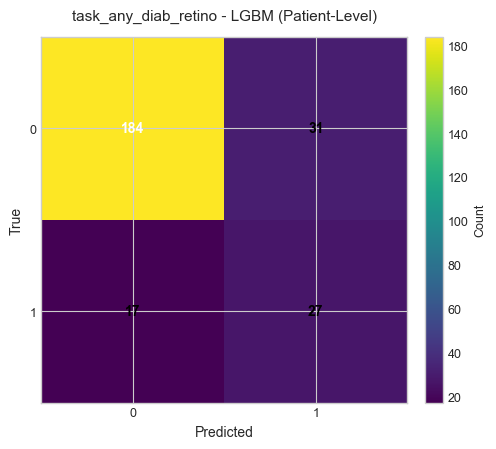

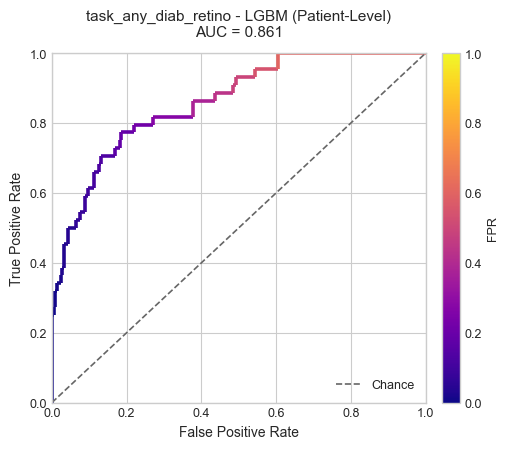


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 60, best weighted val loss: 0.4956
    Optimal threshold: 0.352 (vs default 0.5)
  Accuracy: 0.873
  Balanced Accuracy: 0.679
  F1 Score: 0.507
  Precision: 0.739
  Recall (Sensitivity): 0.386
  ROC AUC: 0.876

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.886     0.972     0.927       215
           1      0.739     0.386     0.507        44

    accuracy                          0.873       259
   macro avg      0.812     0.679     0.717       259
weighted avg      0.861     0.873     0.856       259



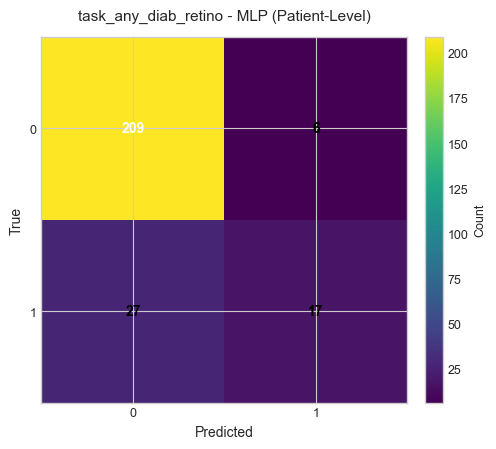

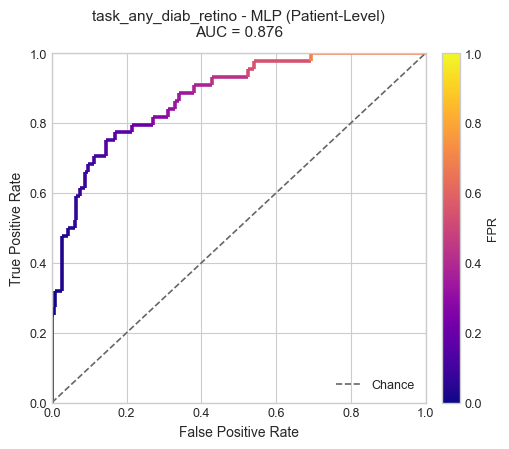


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.217 (vs default 0.5)
  Accuracy: 0.903
  Balanced Accuracy: 0.750
  F1 Score: 0.576
  Precision: 0.607
  Recall (Sensitivity): 0.548
  ROC AUC: 0.865

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.939     0.952     0.946       228
           1      0.607     0.548     0.576        31

    accuracy                          0.903       259
   macro avg      0.773     0.750     0.761       259
weighted avg      0.900     0.903     0.901       259



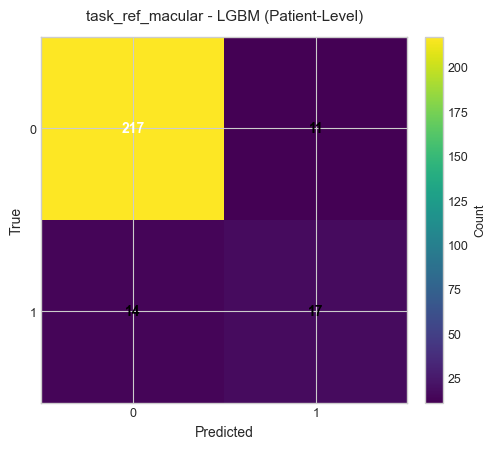

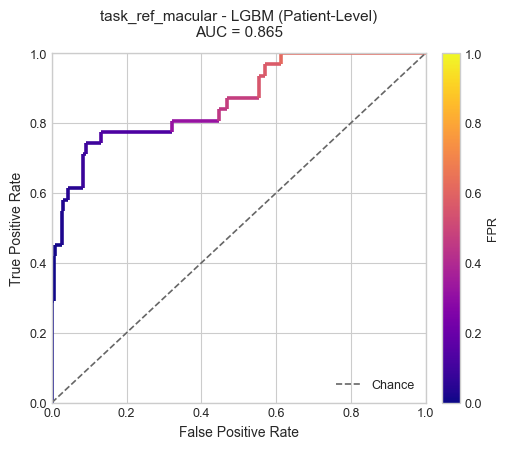


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 97, best weighted val loss: 0.4272
    Optimal threshold: 0.298 (vs default 0.5)
  Accuracy: 0.927
  Balanced Accuracy: 0.777
  F1 Score: 0.655
  Precision: 0.750
  Recall (Sensitivity): 0.581
  ROC AUC: 0.895

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.945     0.974     0.959       228
           1      0.750     0.581     0.655        31

    accuracy                          0.927       259
   macro avg      0.847     0.777     0.807       259
weighted avg      0.921     0.927     0.923       259



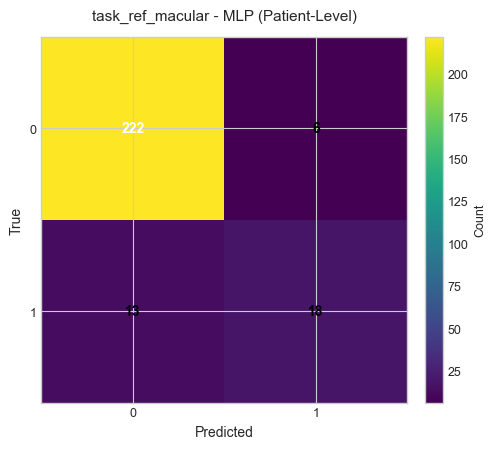

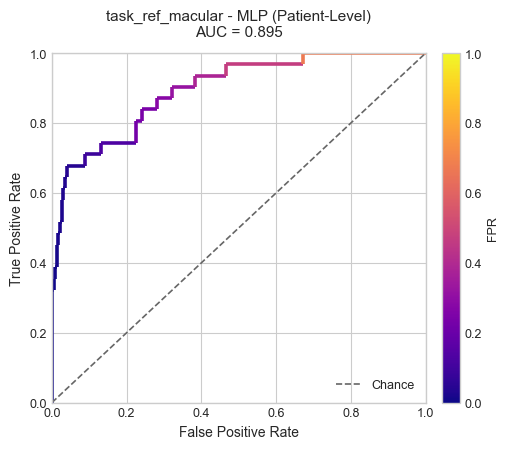


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.848
  Balanced Accuracy: 0.465
  F1 Score (macro): 0.517

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.863     0.990     0.922       210
           1      0.571     0.222     0.320        36
           2      1.000     0.182     0.308        11

    accuracy                          0.848       257
   macro avg      0.811     0.465     0.517       257
weighted avg      0.828     0.848     0.812       257



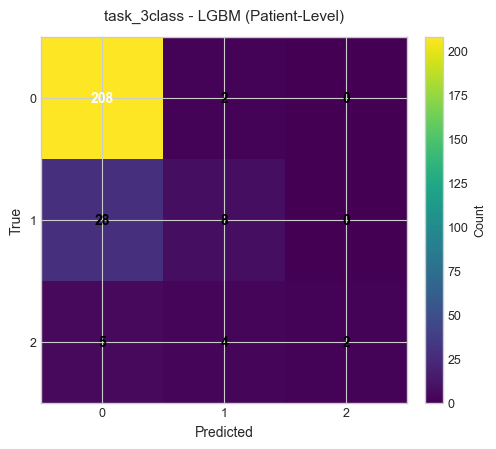


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 105, best weighted val loss: 0.6415
  Accuracy: 0.844
  Balanced Accuracy: 0.463
  F1 Score (macro): 0.515

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.859     0.986     0.918       210
           1      0.571     0.222     0.320        36
           2      1.000     0.182     0.308        11

    accuracy                          0.844       257
   macro avg      0.810     0.463     0.515       257
weighted avg      0.825     0.844     0.808       257



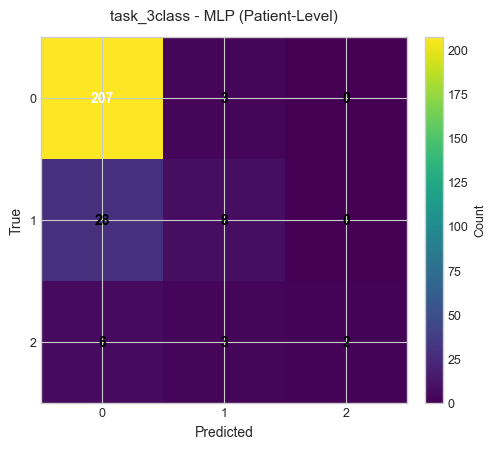


Embedding 2/7: Embeddings_mbrset_dinov3_convnext_base

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.196 (vs default 0.5)
  Accuracy: 0.772
  Balanced Accuracy: 0.664
  F1 Score: 0.427
  Precision: 0.373
  Recall (Sensitivity): 0.500
  ROC AUC: 0.782

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.890     0.828     0.858       215
           1      0.373     0.500     0.427        44

    accuracy                          0.772       259
   macro avg      0.631     0.664     0.643       259
weighted avg      0.802     0.772     0.785       259



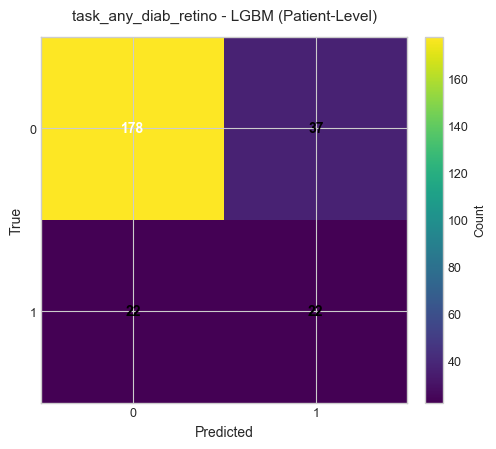

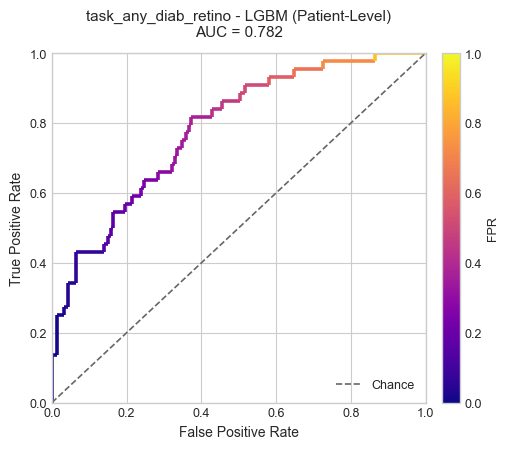


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 84, best weighted val loss: 0.5150
    Optimal threshold: 0.279 (vs default 0.5)
  Accuracy: 0.869
  Balanced Accuracy: 0.686
  F1 Score: 0.514
  Precision: 0.692
  Recall (Sensitivity): 0.409
  ROC AUC: 0.812

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.888     0.963     0.924       215
           1      0.692     0.409     0.514        44

    accuracy                          0.869       259
   macro avg      0.790     0.686     0.719       259
weighted avg      0.855     0.869     0.854       259



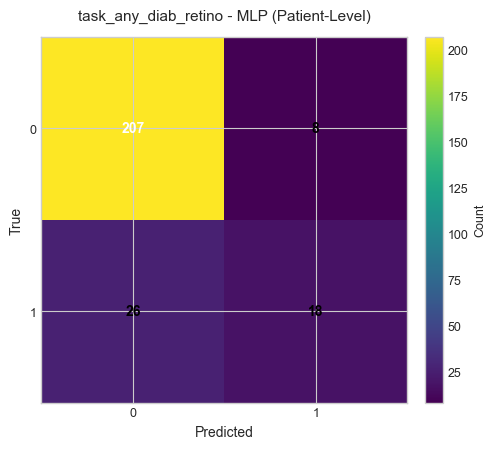

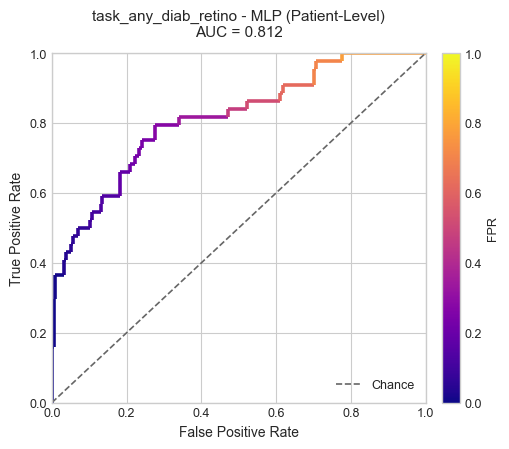


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.115 (vs default 0.5)
  Accuracy: 0.749
  Balanced Accuracy: 0.802
  F1 Score: 0.454
  Precision: 0.307
  Recall (Sensitivity): 0.871
  ROC AUC: 0.865

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.977     0.732     0.837       228
           1      0.307     0.871     0.454        31

    accuracy                          0.749       259
   macro avg      0.642     0.802     0.645       259
weighted avg      0.896     0.749     0.791       259



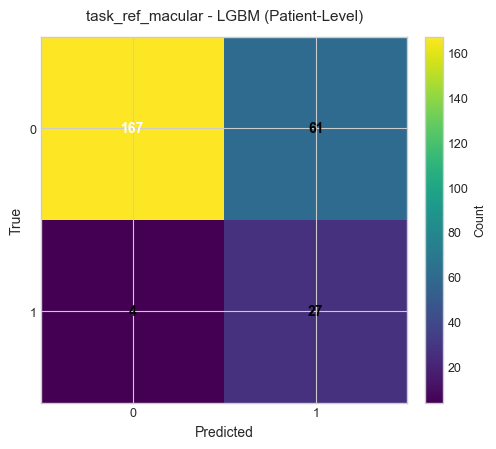

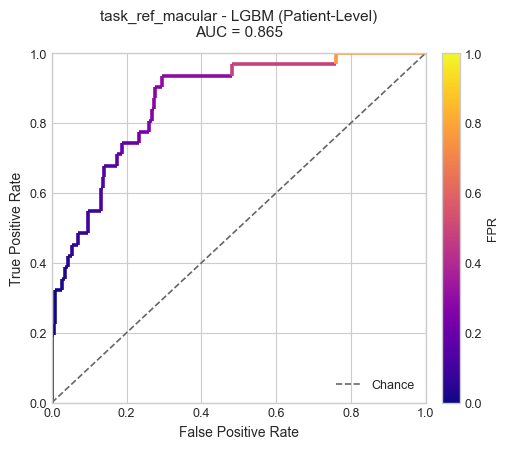


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 93, best weighted val loss: 0.4617
    Optimal threshold: 0.144 (vs default 0.5)
  Accuracy: 0.838
  Balanced Accuracy: 0.769
  F1 Score: 0.500
  Precision: 0.396
  Recall (Sensitivity): 0.677
  ROC AUC: 0.839

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.951     0.860     0.903       228
           1      0.396     0.677     0.500        31

    accuracy                          0.838       259
   macro avg      0.674     0.769     0.702       259
weighted avg      0.885     0.838     0.855       259



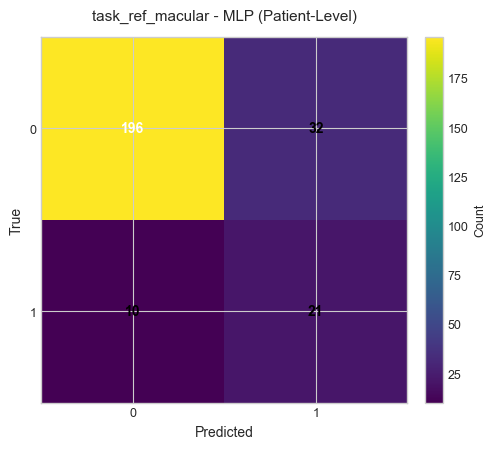

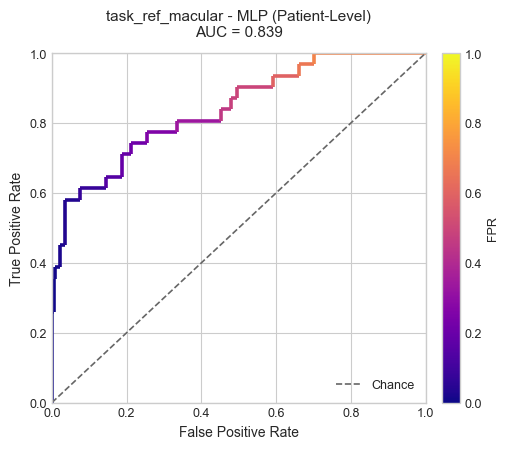


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.848
  Balanced Accuracy: 0.528
  F1 Score (macro): 0.590

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.852     0.990     0.916       210
           1      0.625     0.139     0.227        36
           2      1.000     0.455     0.625        11

    accuracy                          0.848       257
   macro avg      0.826     0.528     0.590       257
weighted avg      0.827     0.848     0.807       257



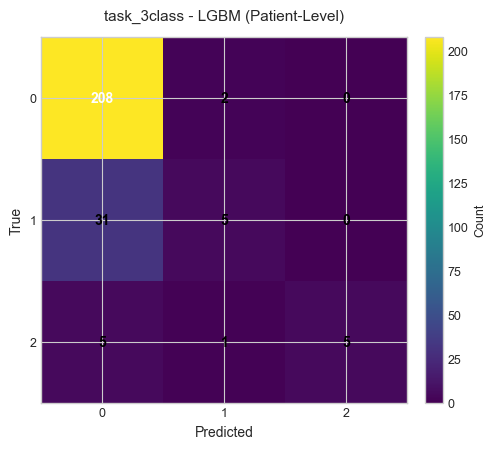


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 376, best weighted val loss: 0.5947
  Accuracy: 0.848
  Balanced Accuracy: 0.471
  F1 Score (macro): 0.527

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.850     1.000     0.919       210
           1      0.714     0.139     0.233        36
           2      1.000     0.273     0.429        11

    accuracy                          0.848       257
   macro avg      0.855     0.471     0.527       257
weighted avg      0.838     0.848     0.802       257



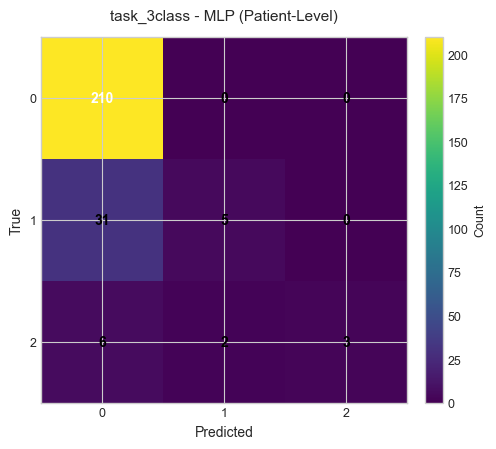


Embedding 3/7: Embeddings_mbrset_dinov3_vitb16

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.444 (vs default 0.5)
  Accuracy: 0.853
  Balanced Accuracy: 0.622
  F1 Score: 0.387
  Precision: 0.667
  Recall (Sensitivity): 0.273
  ROC AUC: 0.770

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.867     0.972     0.917       215
           1      0.667     0.273     0.387        44

    accuracy                          0.853       259
   macro avg      0.767     0.622     0.652       259
weighted avg      0.833     0.853     0.827       259



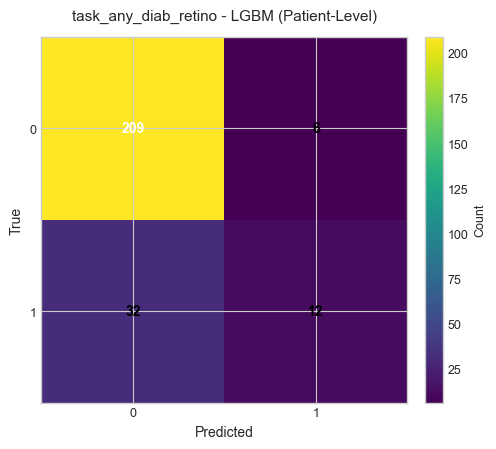

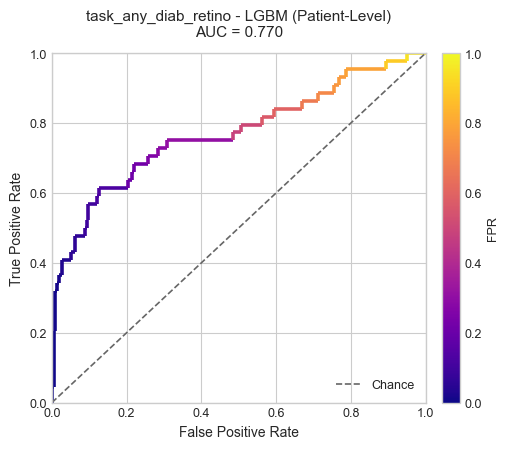


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 67, best weighted val loss: 0.4550
    Optimal threshold: 0.177 (vs default 0.5)
  Accuracy: 0.776
  Balanced Accuracy: 0.730
  F1 Score: 0.500
  Precision: 0.403
  Recall (Sensitivity): 0.659
  ROC AUC: 0.805

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.920     0.800     0.856       215
           1      0.403     0.659     0.500        44

    accuracy                          0.776       259
   macro avg      0.661     0.730     0.678       259
weighted avg      0.832     0.776     0.795       259



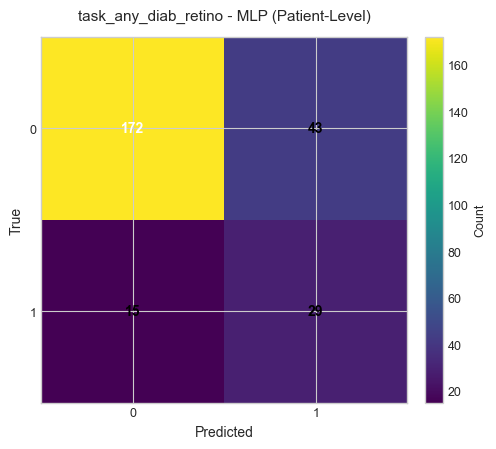

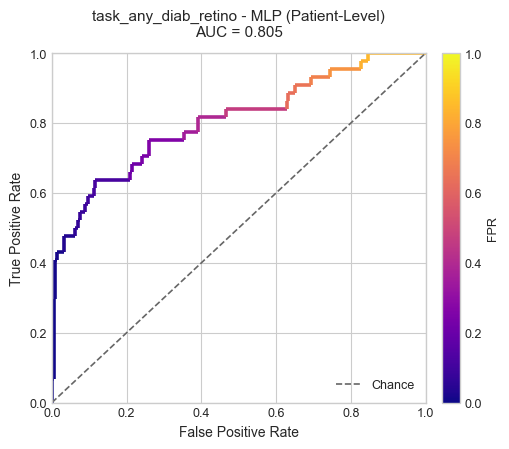


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.312 (vs default 0.5)
  Accuracy: 0.927
  Balanced Accuracy: 0.777
  F1 Score: 0.655
  Precision: 0.750
  Recall (Sensitivity): 0.581
  ROC AUC: 0.855

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.945     0.974     0.959       228
           1      0.750     0.581     0.655        31

    accuracy                          0.927       259
   macro avg      0.847     0.777     0.807       259
weighted avg      0.921     0.927     0.923       259



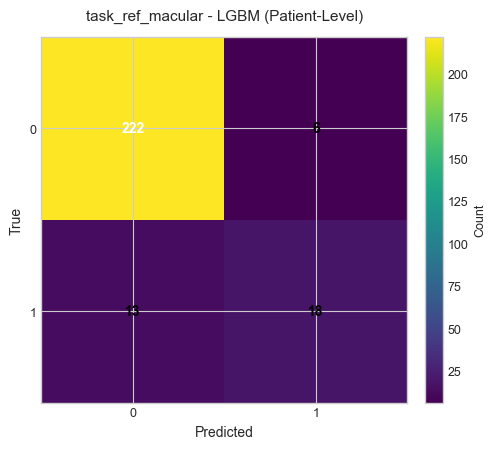

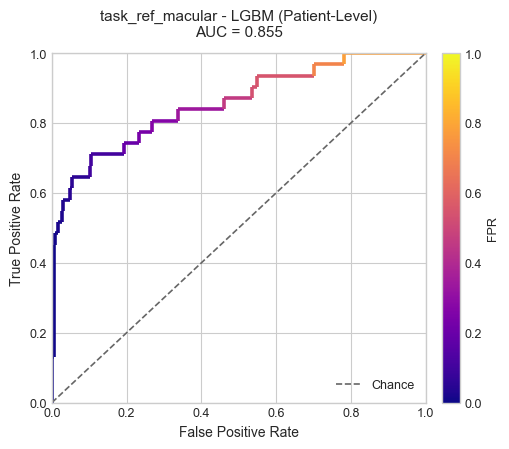


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 104, best weighted val loss: 0.4166
    Optimal threshold: 0.129 (vs default 0.5)
  Accuracy: 0.838
  Balanced Accuracy: 0.782
  F1 Score: 0.512
  Precision: 0.400
  Recall (Sensitivity): 0.710
  ROC AUC: 0.837

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.956     0.855     0.903       228
           1      0.400     0.710     0.512        31

    accuracy                          0.838       259
   macro avg      0.678     0.782     0.707       259
weighted avg      0.889     0.838     0.856       259



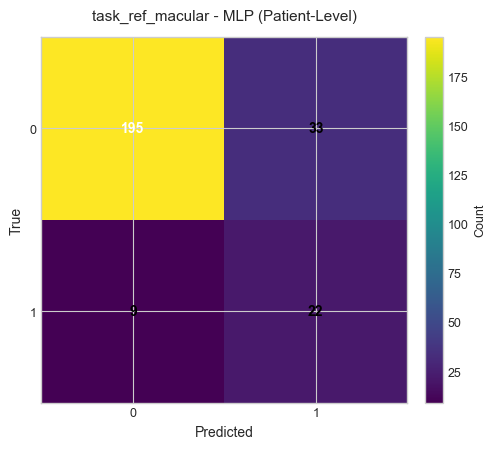

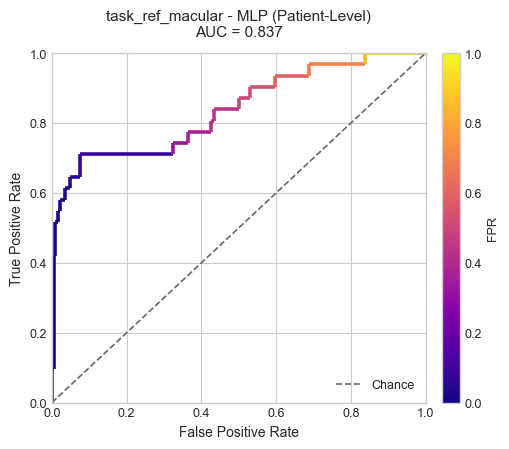


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.872
  Balanced Accuracy: 0.568
  F1 Score (macro): 0.649

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.868     1.000     0.929       210
           1      0.900     0.250     0.391        36
           2      1.000     0.455     0.625        11

    accuracy                          0.872       257
   macro avg      0.923     0.568     0.649       257
weighted avg      0.878     0.872     0.841       257



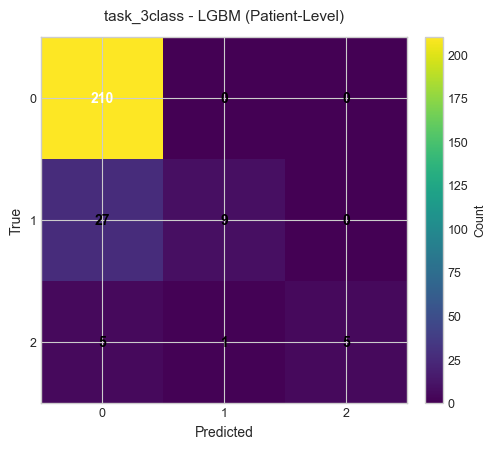


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 144, best weighted val loss: 0.5771
  Accuracy: 0.856
  Balanced Accuracy: 0.554
  F1 Score (macro): 0.623

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.870     0.986     0.924       210
           1      0.571     0.222     0.320        36
           2      1.000     0.455     0.625        11

    accuracy                          0.856       257
   macro avg      0.814     0.554     0.623       257
weighted avg      0.834     0.856     0.827       257



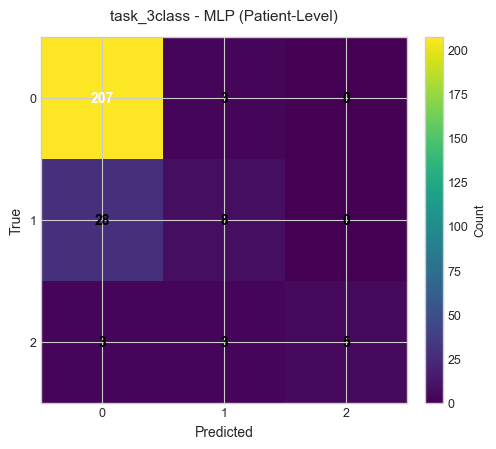


Embedding 4/7: Embeddings_mbrset_RETFound_dinov2_shanghai

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.282 (vs default 0.5)
  Accuracy: 0.838
  Balanced Accuracy: 0.685
  F1 Score: 0.488
  Precision: 0.526
  Recall (Sensitivity): 0.455
  ROC AUC: 0.790

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.891     0.916     0.904       215
           1      0.526     0.455     0.488        44

    accuracy                          0.838       259
   macro avg      0.709     0.685     0.696       259
weighted avg      0.829     0.838     0.833       259



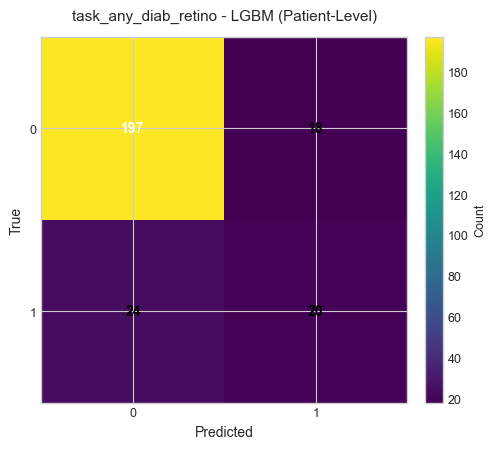

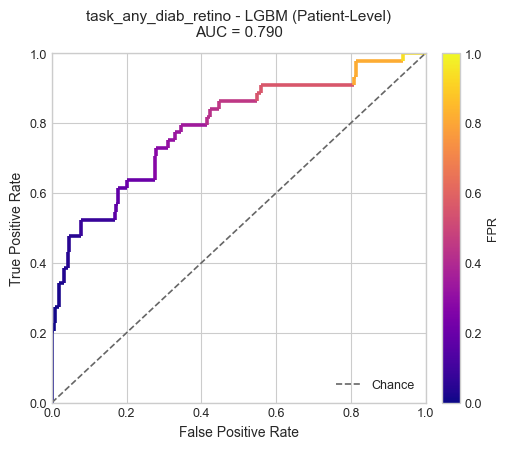


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 44, best weighted val loss: 0.4661
    Optimal threshold: 0.236 (vs default 0.5)
  Accuracy: 0.846
  Balanced Accuracy: 0.726
  F1 Score: 0.545
  Precision: 0.545
  Recall (Sensitivity): 0.545
  ROC AUC: 0.817

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.907     0.907     0.907       215
           1      0.545     0.545     0.545        44

    accuracy                          0.846       259
   macro avg      0.726     0.726     0.726       259
weighted avg      0.846     0.846     0.846       259



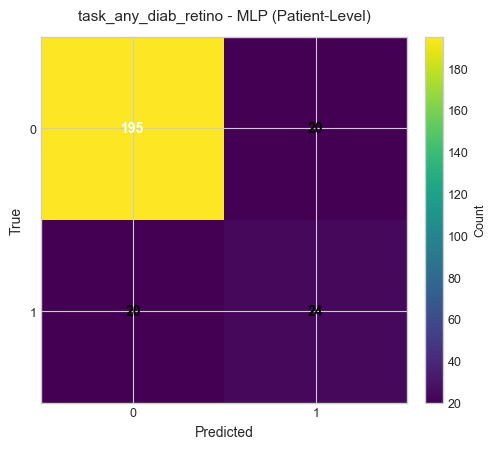

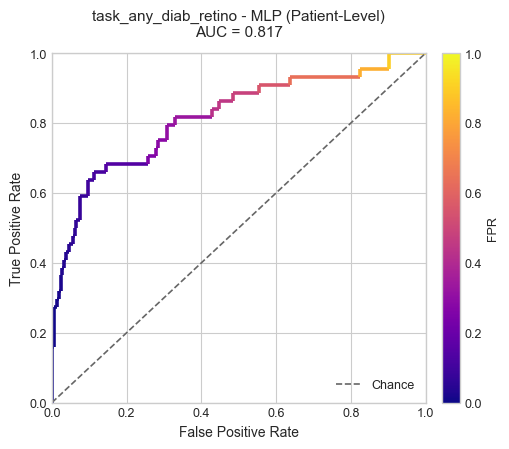


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.153 (vs default 0.5)
  Accuracy: 0.896
  Balanced Accuracy: 0.843
  F1 Score: 0.640
  Precision: 0.545
  Recall (Sensitivity): 0.774
  ROC AUC: 0.901

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.967     0.912     0.939       228
           1      0.545     0.774     0.640        31

    accuracy                          0.896       259
   macro avg      0.756     0.843     0.790       259
weighted avg      0.917     0.896     0.903       259



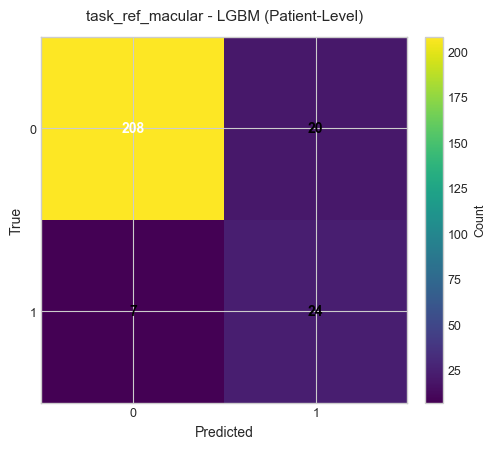

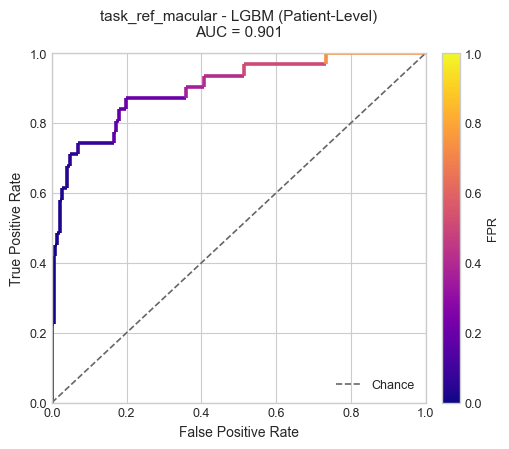


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 110, best weighted val loss: 0.4016
    Optimal threshold: 0.229 (vs default 0.5)
  Accuracy: 0.915
  Balanced Accuracy: 0.798
  F1 Score: 0.645
  Precision: 0.645
  Recall (Sensitivity): 0.645
  ROC AUC: 0.884

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.952     0.952     0.952       228
           1      0.645     0.645     0.645        31

    accuracy                          0.915       259
   macro avg      0.798     0.798     0.798       259
weighted avg      0.915     0.915     0.915       259



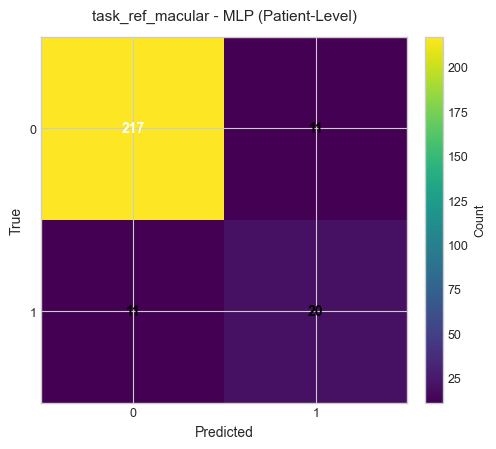

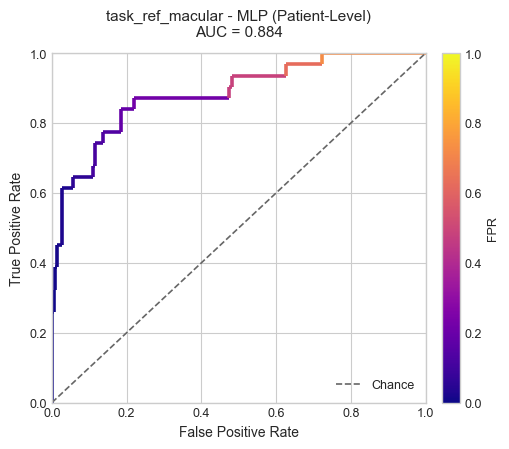


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.844
  Balanced Accuracy: 0.519
  F1 Score (macro): 0.563

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.856     0.990     0.918       210
           1      0.500     0.111     0.182        36
           2      0.833     0.455     0.588        11

    accuracy                          0.844       257
   macro avg      0.730     0.519     0.563       257
weighted avg      0.805     0.844     0.801       257



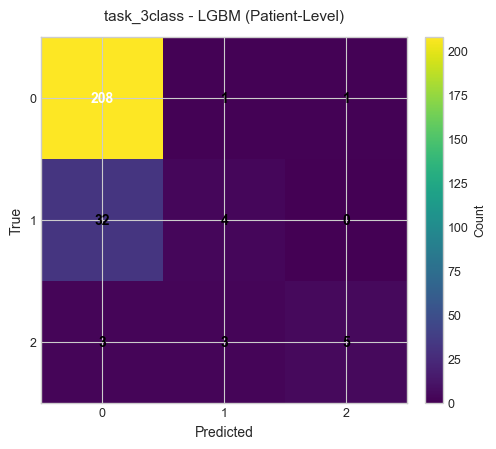


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 221, best weighted val loss: 0.5956
  Accuracy: 0.860
  Balanced Accuracy: 0.548
  F1 Score (macro): 0.617

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.867     0.995     0.927       210
           1      0.636     0.194     0.298        36
           2      1.000     0.455     0.625        11

    accuracy                          0.860       257
   macro avg      0.835     0.548     0.617       257
weighted avg      0.841     0.860     0.826       257



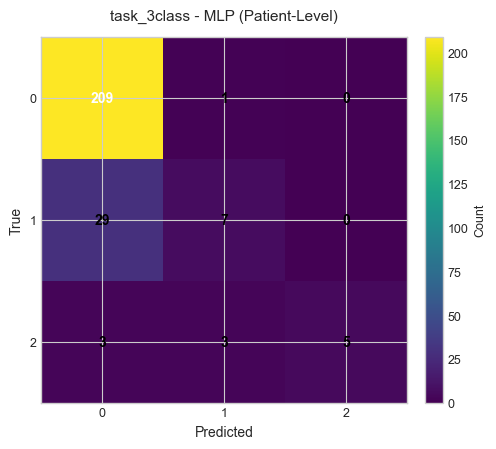


Embedding 5/7: Embeddings_mbrset_RETFound_mae_natureCFP

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.268 (vs default 0.5)
  Accuracy: 0.772
  Balanced Accuracy: 0.628
  F1 Score: 0.379
  Precision: 0.353
  Recall (Sensitivity): 0.409
  ROC AUC: 0.794

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.875     0.847     0.861       215
           1      0.353     0.409     0.379        44

    accuracy                          0.772       259
   macro avg      0.614     0.628     0.620       259
weighted avg      0.786     0.772     0.779       259



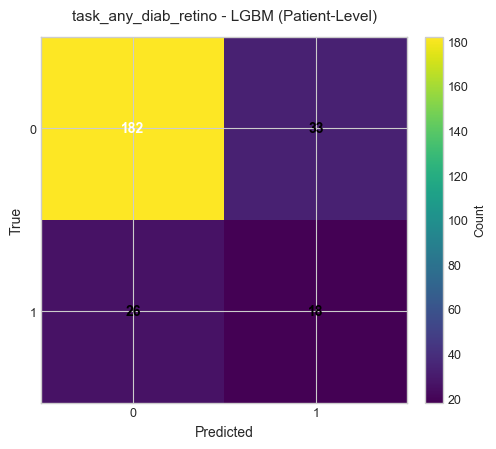

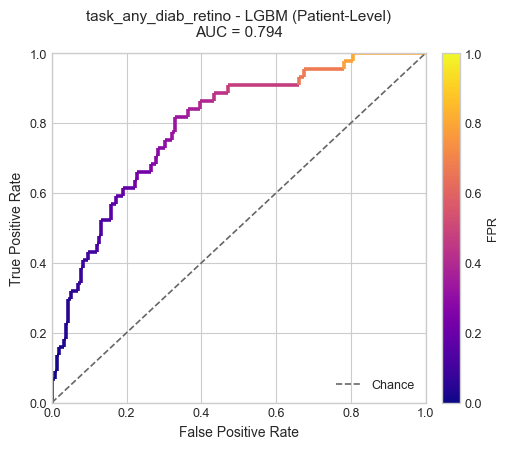


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 58, best weighted val loss: 0.5503
    Optimal threshold: 0.323 (vs default 0.5)
  Accuracy: 0.853
  Balanced Accuracy: 0.668
  F1 Score: 0.472
  Precision: 0.607
  Recall (Sensitivity): 0.386
  ROC AUC: 0.835

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.883     0.949     0.915       215
           1      0.607     0.386     0.472        44

    accuracy                          0.853       259
   macro avg      0.745     0.668     0.694       259
weighted avg      0.836     0.853     0.840       259



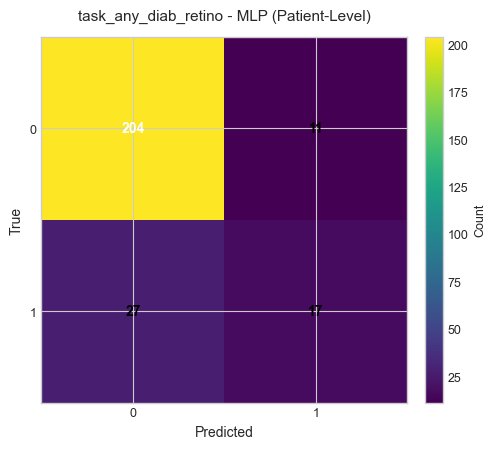

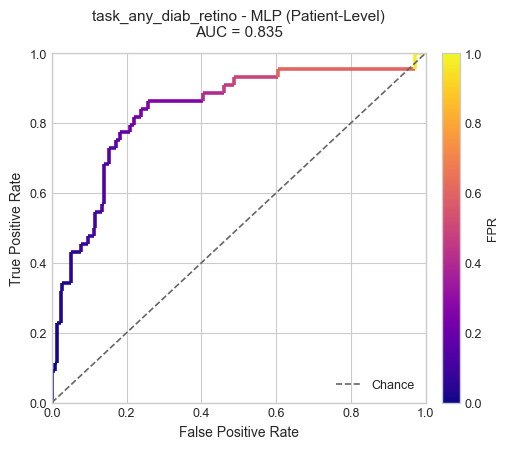


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.252 (vs default 0.5)
  Accuracy: 0.838
  Balanced Accuracy: 0.629
  F1 Score: 0.344
  Precision: 0.333
  Recall (Sensitivity): 0.355
  ROC AUC: 0.808

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.912     0.904     0.907       228
           1      0.333     0.355     0.344        31

    accuracy                          0.838       259
   macro avg      0.622     0.629     0.626       259
weighted avg      0.842     0.838     0.840       259



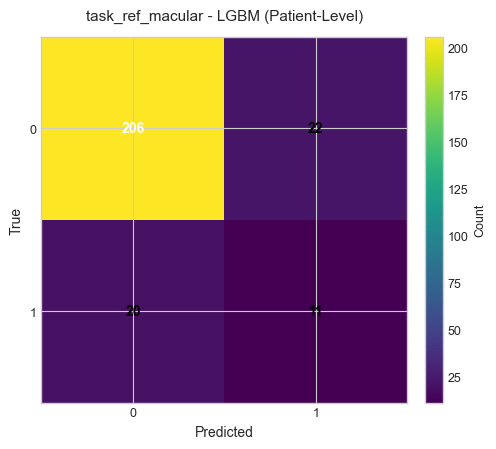

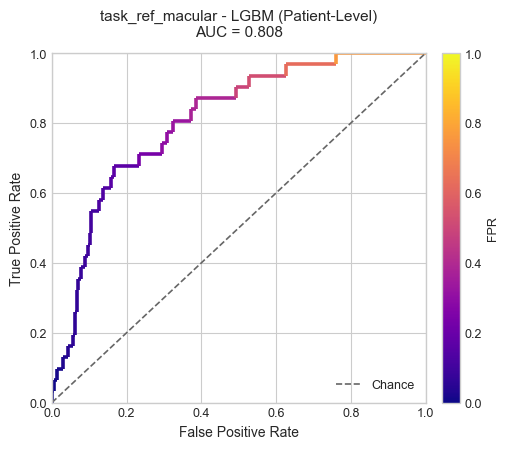


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 104, best weighted val loss: 0.4865
    Optimal threshold: 0.251 (vs default 0.5)
  Accuracy: 0.857
  Balanced Accuracy: 0.626
  F1 Score: 0.351
  Precision: 0.385
  Recall (Sensitivity): 0.323
  ROC AUC: 0.818

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.910     0.930     0.920       228
           1      0.385     0.323     0.351        31

    accuracy                          0.857       259
   macro avg      0.647     0.626     0.635       259
weighted avg      0.847     0.857     0.852       259



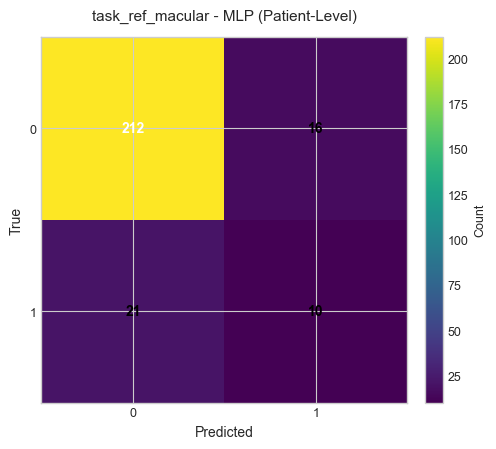

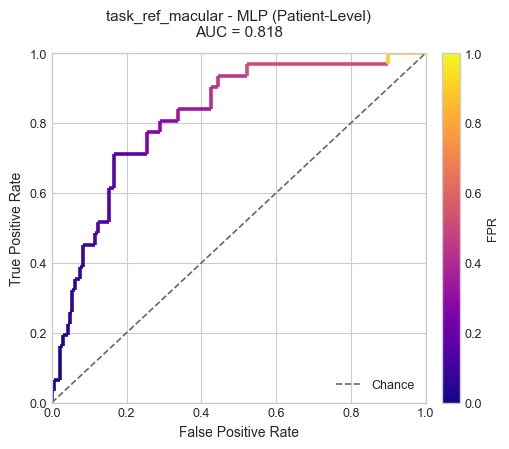


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.829
  Balanced Accuracy: 0.397
  F1 Score (macro): 0.420

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.835     0.990     0.906       210
           1      0.571     0.111     0.186        36
           2      1.000     0.091     0.167        11

    accuracy                          0.829       257
   macro avg      0.802     0.397     0.420       257
weighted avg      0.805     0.829     0.774       257



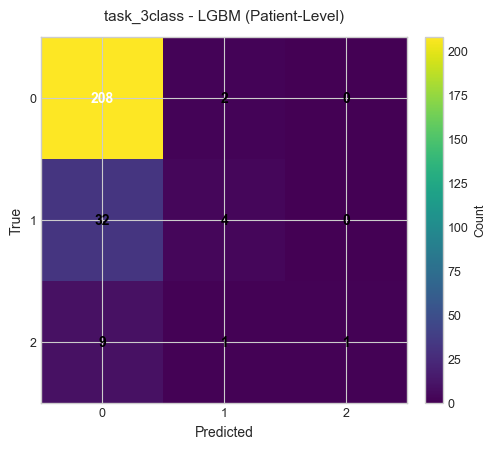


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 188, best weighted val loss: 0.7598
  Accuracy: 0.829
  Balanced Accuracy: 0.361
  F1 Score (macro): 0.353

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.827     1.000     0.905       210
           1      1.000     0.083     0.154        36
           2      0.000     0.000     0.000        11

    accuracy                          0.829       257
   macro avg      0.609     0.361     0.353       257
weighted avg      0.816     0.829     0.761       257



c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

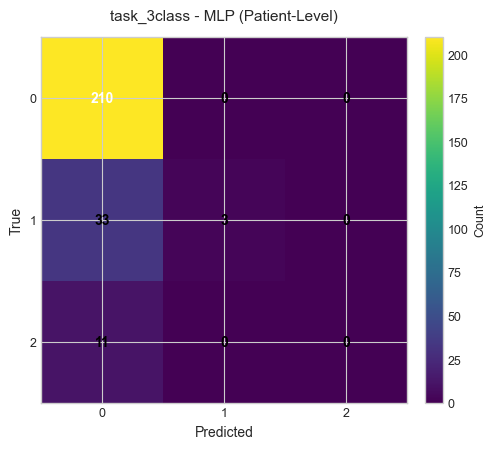


Embedding 6/7: Embeddings_mbrset_RETFound_mae_shanghai

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.168 (vs default 0.5)
  Accuracy: 0.575
  Balanced Accuracy: 0.609
  F1 Score: 0.345
  Precision: 0.234
  Recall (Sensitivity): 0.659
  ROC AUC: 0.683

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.889     0.558     0.686       215
           1      0.234     0.659     0.345        44

    accuracy                          0.575       259
   macro avg      0.561     0.609     0.515       259
weighted avg      0.778     0.575     0.628       259



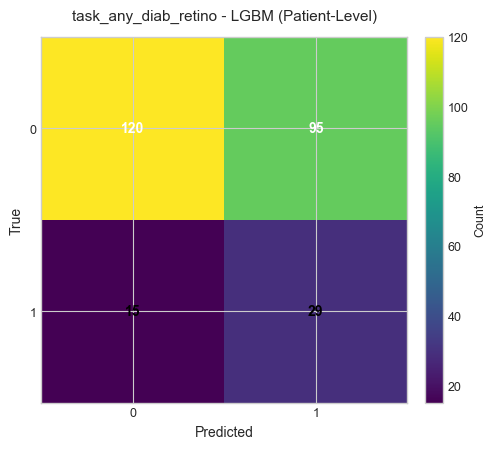

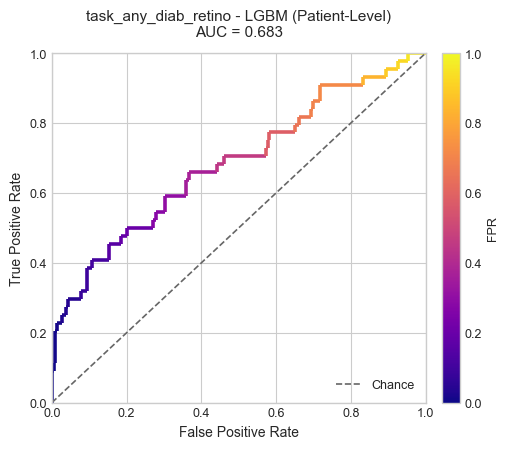


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 146, best weighted val loss: 0.5664
    Optimal threshold: 0.173 (vs default 0.5)
  Accuracy: 0.606
  Balanced Accuracy: 0.618
  F1 Score: 0.354
  Precision: 0.246
  Recall (Sensitivity): 0.636
  ROC AUC: 0.677

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.890     0.600     0.717       215
           1      0.246     0.636     0.354        44

    accuracy                          0.606       259
   macro avg      0.568     0.618     0.536       259
weighted avg      0.780     0.606     0.655       259



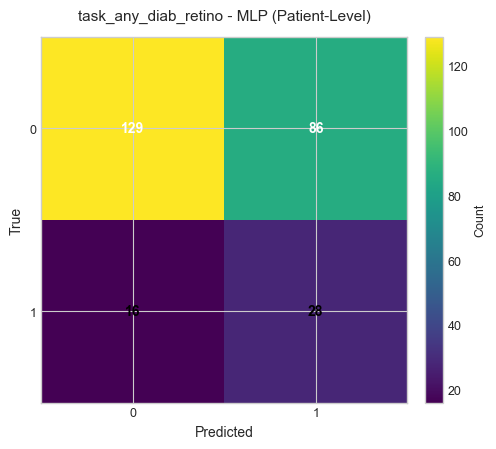

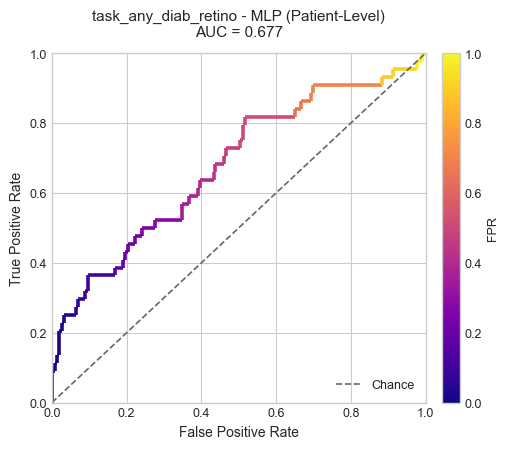


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.182 (vs default 0.5)
  Accuracy: 0.772
  Balanced Accuracy: 0.676
  F1 Score: 0.366
  Precision: 0.274
  Recall (Sensitivity): 0.548
  ROC AUC: 0.719

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.929     0.803     0.861       228
           1      0.274     0.548     0.366        31

    accuracy                          0.772       259
   macro avg      0.602     0.676     0.613       259
weighted avg      0.851     0.772     0.802       259



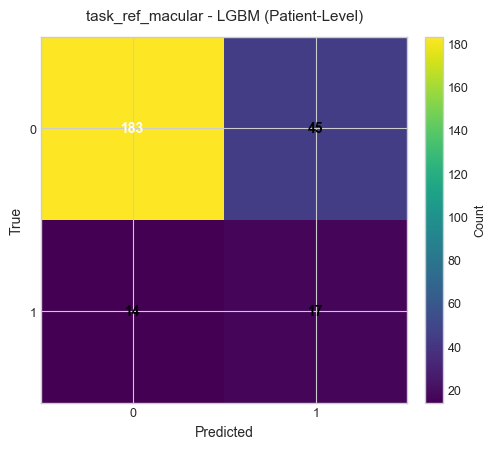

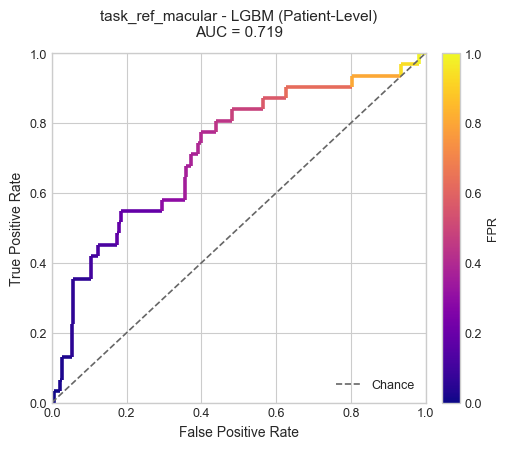


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 203, best weighted val loss: 0.5288
    Optimal threshold: 0.192 (vs default 0.5)
  Accuracy: 0.784
  Balanced Accuracy: 0.598
  F1 Score: 0.282
  Precision: 0.234
  Recall (Sensitivity): 0.355
  ROC AUC: 0.689

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.906     0.842     0.873       228
           1      0.234     0.355     0.282        31

    accuracy                          0.784       259
   macro avg      0.570     0.598     0.577       259
weighted avg      0.825     0.784     0.802       259



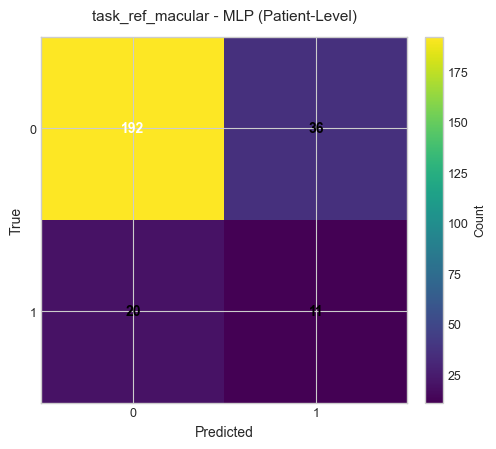

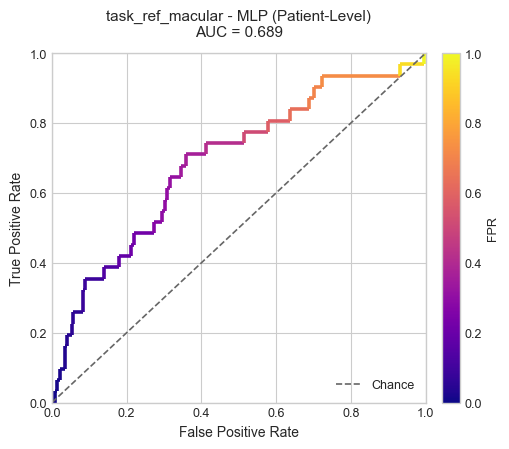


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-

  Accuracy: 0.817
  Balanced Accuracy: 0.333
  F1 Score (macro): 0.300

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.817     1.000     0.899       210
           1      0.000     0.000     0.000        36
           2      0.000     0.000     0.000        11

    accuracy                          0.817       257
   macro avg      0.272     0.333     0.300       257
weighted avg      0.668     0.817     0.735       257



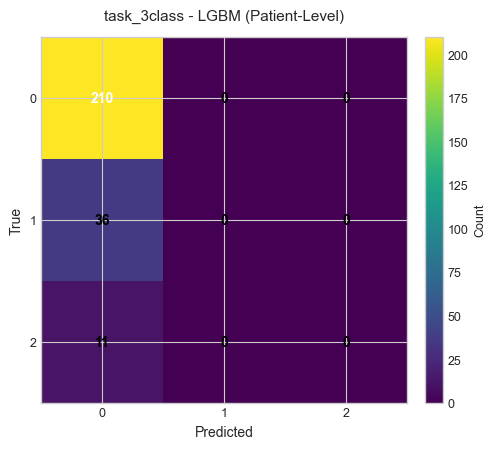


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 77, best weighted val loss: 0.8248
  Accuracy: 0.825
  Balanced Accuracy: 0.352
  F1 Score (macro): 0.336

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.824     1.000     0.903       210
           1      1.000     0.056     0.105        36
           2      0.000     0.000     0.000        11

    accuracy                          0.825       257
   macro avg      0.608     0.352     0.336       257
weighted avg      0.813     0.825     0.753       257



c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

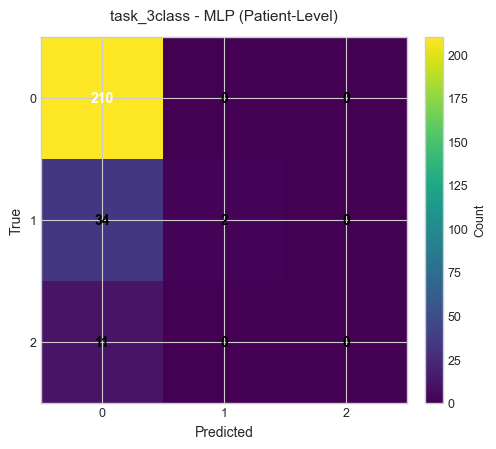


Embedding 7/7: Embeddings_vit_base_mbrset

--- Task: task_any_diab_retino (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1595), np.int64(1): np.int64(469)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.287 (vs default 0.5)
  Accuracy: 0.826
  Balanced Accuracy: 0.651
  F1 Score: 0.430
  Precision: 0.486
  Recall (Sensitivity): 0.386
  ROC AUC: 0.801

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.879     0.916     0.897       215
           1      0.486     0.386     0.430        44

    accuracy                          0.826       259
   macro avg      0.683     0.651     0.664       259
weighted avg      0.813     0.826     0.818       259



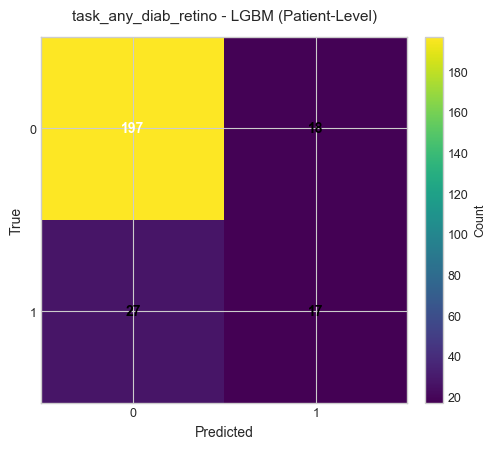

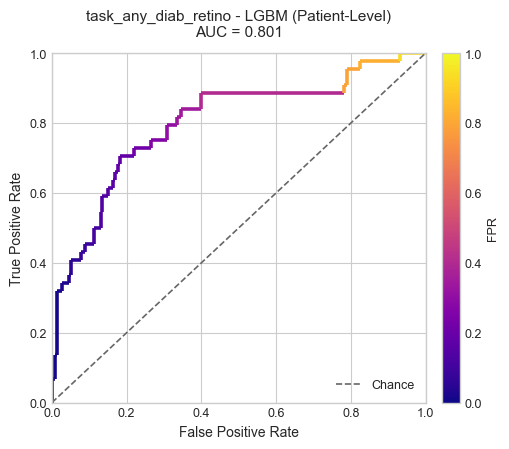


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 62, best weighted val loss: 0.5210
    Optimal threshold: 0.220 (vs default 0.5)
  Accuracy: 0.811
  Balanced Accuracy: 0.732
  F1 Score: 0.524
  Precision: 0.458
  Recall (Sensitivity): 0.614
  ROC AUC: 0.801

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.915     0.851     0.882       215
           1      0.458     0.614     0.524        44

    accuracy                          0.811       259
   macro avg      0.686     0.732     0.703       259
weighted avg      0.837     0.811     0.821       259



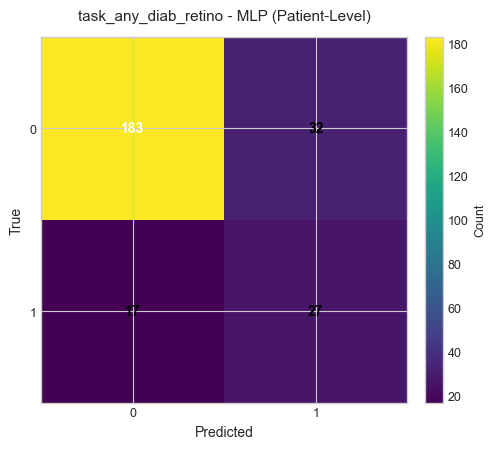

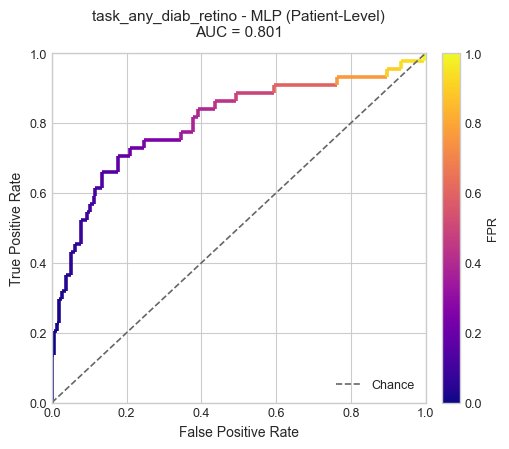


--- Task: task_ref_macular (binary) ---
  Train: 2064 images, 1032 patients
  Test: 518 images, 259 patients
  Class distribution (train): {np.int64(0): np.int64(1697), np.int64(1): np.int64(367)}
  Applying PCA (n_components=30)...
  New feature shape: (2064, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


    Optimal threshold: 0.295 (vs default 0.5)
  Accuracy: 0.900
  Balanced Accuracy: 0.706
  F1 Score: 0.519
  Precision: 0.609
  Recall (Sensitivity): 0.452
  ROC AUC: 0.814

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.928     0.961     0.944       228
           1      0.609     0.452     0.519        31

    accuracy                          0.900       259
   macro avg      0.768     0.706     0.731       259
weighted avg      0.890     0.900     0.893       259



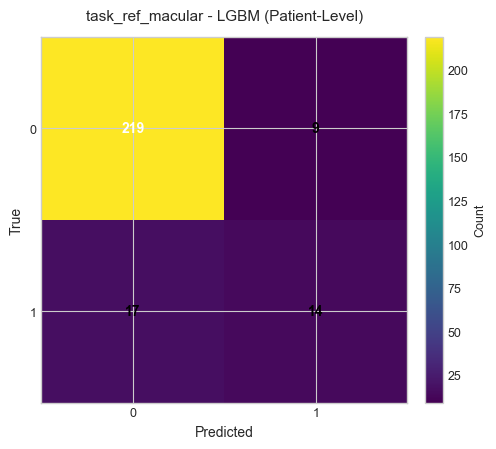

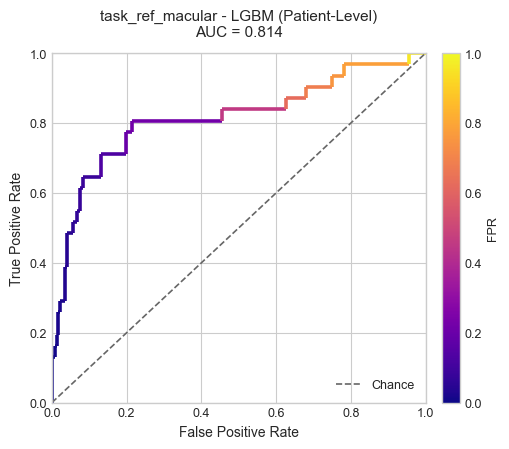


  Training MLP...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Stopped at epoch 53, best weighted val loss: 0.5002
    Optimal threshold: 0.126 (vs default 0.5)
  Accuracy: 0.788
  Balanced Accuracy: 0.768
  F1 Score: 0.455
  Precision: 0.329
  Recall (Sensitivity): 0.742
  ROC AUC: 0.800

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.958     0.794     0.868       228
           1      0.329     0.742     0.455        31

    accuracy                          0.788       259
   macro avg      0.643     0.768     0.662       259
weighted avg      0.882     0.788     0.819       259



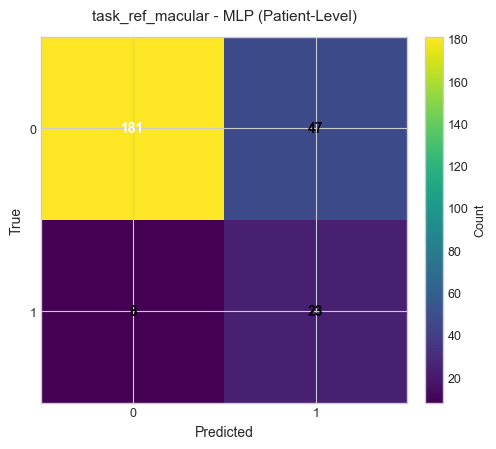

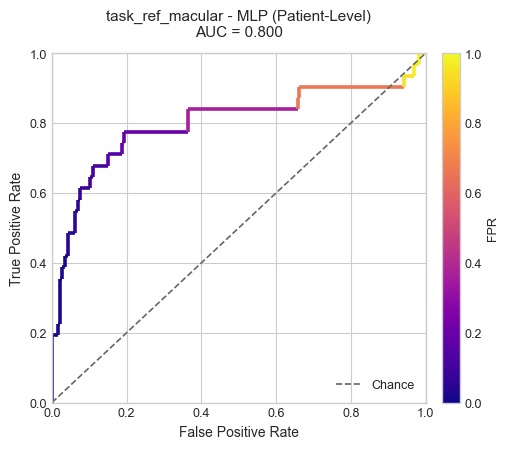


--- Task: task_3class (multiclass) ---
  Train: 1949 images, 1017 patients
  Test: 488 images, 257 patients
  Class distribution (train): {np.int64(0): np.int64(1480), np.int64(1): np.int64(386), np.int64(2): np.int64(83)}
  Applying PCA (n_components=30)...
  New feature shape: (1949, 30)

  Training LGBM...


c:\Users\Julian\OneDrive\Desktop\testing-retina-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.837
  Balanced Accuracy: 0.437
  F1 Score (macro): 0.482

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.842     0.990     0.910       210
           1      0.625     0.139     0.227        36
           2      1.000     0.182     0.308        11

    accuracy                          0.837       257
   macro avg      0.822     0.437     0.482       257
weighted avg      0.818     0.837     0.789       257



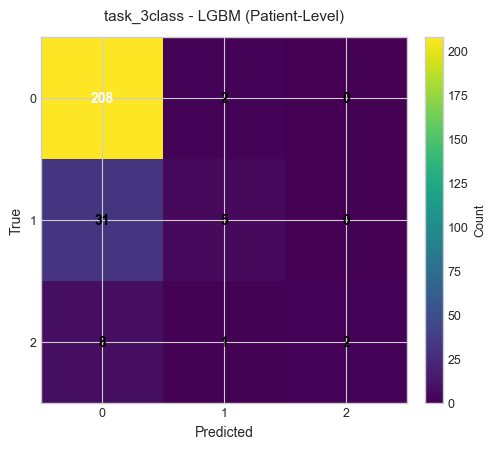


  Training MLP...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Stopped at epoch 223, best weighted val loss: 0.7107
  Accuracy: 0.840
  Balanced Accuracy: 0.410
  F1 Score (macro): 0.437

  Classification Report (Patient-Level):
              precision    recall  f1-score   support

           0      0.847     1.000     0.917       210
           1      0.625     0.139     0.227        36
           2      1.000     0.091     0.167        11

    accuracy                          0.840       257
   macro avg      0.824     0.410     0.437       257
weighted avg      0.822     0.840     0.788       257



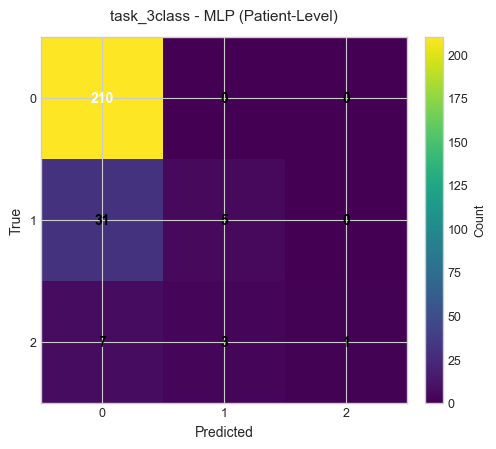


Training and evaluation complete!


In [20]:
# Storage for results
all_results = []

for emb_idx, emb_path in enumerate(embedding_files):
    print(f"\n{'='*80}")
    print(f"Embedding {emb_idx+1}/{len(embedding_files)}: {emb_path.stem}")
    print(f"{'='*80}")
    
    # Load dataset
    ds = load_retina_embeddings_dataset(
        dataset=DATASET_NAME,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=VIEW,
    )
    
    # Apply split
    train_df, test_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")
    
    # Determine available tasks
    tasks = list(BINARY_TASKS)
    if "task_3class" in ds.df.columns:
        tasks.append("task_3class")
    
    # Loop over tasks
    for task in tasks:
        if task not in ds.df.columns:
            continue
        
        task_type = "binary" if task in BINARY_TASKS else "multiclass"
        display_task = BINARY_TASK_MAP.get(task, task)
        
        print(f"\n--- Task: {display_task} ({task_type}) ---")
        
        # Prepare data
        train_work = train_df.dropna(subset=[task]).copy()
        test_work = test_df.dropna(subset=[task]).copy()
        
        if train_work.empty or test_work.empty:
            print(f"  Skipping {task}: insufficient data")
            continue
        
        X_train = train_work.loc[:, ds.feature_cols].to_numpy(dtype=np.float32)
        y_train = train_work[task].astype(int).to_numpy()
        X_test = test_work.loc[:, ds.feature_cols].to_numpy(dtype=np.float32)
        y_test = test_work[task].astype(int).to_numpy()
        
        # Print class distribution
        classes, counts = np.unique(y_train, return_counts=True)
        print(f"  Train: {len(X_train)} images, {train_work['patient_id'].nunique()} patients")
        print(f"  Test: {len(X_test)} images, {test_work['patient_id'].nunique()} patients")
        print(f"  Class distribution (train): {dict(zip(classes.astype(int), counts))}")

        # Apply PCA if enabled
        if USE_PCA:
            print(f"  Applying PCA (n_components={PCA_N_COMPONENTS})...")
            pca = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_SEED)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            print(f"  New feature shape: {X_train.shape}")

        # Resolve per-embedding configs (overrides applied if available)
        lgbm_cfg, lgbm_match = resolve_config("lgbm", task_type, emb_path.stem)
        mlp_cfg, mlp_match = resolve_config("mlp", task_type, emb_path.stem)
        match_name = lgbm_match or mlp_match
        if match_name:
            print(f"  Per-embedding overrides applied (matched: {match_name})")
        
        # Train both models
        for model_name in ["lgbm", "mlp"]:
            print(f"\n  Training {model_name.upper()}...")
            
            if model_name == "lgbm":
                model = LGBMClassifier(
                    n_estimators=lgbm_cfg["n_estimators"],
                    num_leaves=lgbm_cfg["num_leaves"],
                    min_child_samples=lgbm_cfg["min_child_samples"],
                    reg_lambda=lgbm_cfg["reg_lambda"],
                    reg_alpha=lgbm_cfg["reg_alpha"],
                    subsample=lgbm_cfg["subsample"],
                    colsample_bytree=lgbm_cfg["colsample_bytree"],
                    min_split_gain=lgbm_cfg["min_split_gain"],
                    learning_rate=lgbm_cfg["learning_rate"],
                    random_state=RANDOM_SEED,
                    n_jobs=CPU_COUNT,
                    class_weight=lgbm_cfg.get("class_weight", None),
                    verbose=-1,
                )
                
                # Use early stopping on internal validation split
                from sklearn.model_selection import train_test_split
                X_tr, X_val, y_tr, y_val = train_test_split(
                    X_train, y_train, test_size=0.15, random_state=RANDOM_SEED, stratify=y_train
                )
                
                # Compute manual weights (dampened) to avoid 'balanced' spikes while strictly improving F1
                train_weights = compute_balanced_weights(y_tr)
                
                model.fit(
                    X_tr, y_tr,
                    sample_weight=train_weights,
                    eval_set=[(X_val, y_val)],
                    callbacks=[
                        early_stopping(stopping_rounds=150, verbose=False),
                        log_evaluation(period=0),
                    ],
                )
                
                # Get predictions
                if task_type == "binary":
                    y_proba_test = model.predict_proba(X_test)[:, 1]
                    # Optimal threshold via Youden's J on validation set
                    val_proba_lgbm = model.predict_proba(X_val)[:, 1]
                    opt_thresh = find_optimal_threshold(y_val, val_proba_lgbm)
                    y_pred_test = (y_proba_test >= opt_thresh).astype(int)
                    print(f"    Optimal threshold: {opt_thresh:.3f} (vs default 0.5)")
                else:
                    y_proba_test = model.predict_proba(X_test)
                    y_pred_test = y_proba_test.argmax(axis=1)
            
            else:  # MLP
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s = scaler.transform(X_test)
                
                # Create internal validation split for proper early stopping
                from sklearn.model_selection import train_test_split
                X_tr_s, X_val_s, y_tr, y_val_mlp = train_test_split(
                    X_train_s, y_train, test_size=0.15, random_state=RANDOM_SEED, stratify=y_train
                )
                
                # Compute balanced sample weights for class-aware validation
                val_weights = compute_balanced_weights(y_val_mlp)
                warmup = mlp_cfg.get("warmup_epochs", 0)
                print(f"    Config: hidden={mlp_cfg['hidden_layer_sizes']}, alpha={mlp_cfg['alpha']}, lr={mlp_cfg['learning_rate_init']}, warmup={warmup}")
                print(f"    Training on original data ({len(y_tr)} samples) with weighted validation")
                
                clf = MLPClassifier(
                    hidden_layer_sizes=mlp_cfg["hidden_layer_sizes"],
                    alpha=mlp_cfg["alpha"],
                    learning_rate_init=mlp_cfg["learning_rate_init"],
                    batch_size=mlp_cfg["batch_size"],
                    max_iter=1,
                    warm_start=True,
                    early_stopping=False,
                    random_state=RANDOM_SEED,
                )
                
                # Manual training loop: train on original data, weighted validation loss
                labels = np.unique(np.concatenate([y_tr, y_val_mlp]))
                best_loss = float("inf")
                patience_counter = 0
                
                for epoch in range(1, mlp_cfg["max_epochs"] + 1):
                    clf.fit(X_tr_s, y_tr)
                    
                    # Weighted validation loss — sensitive to minority classes
                    val_proba = clf.predict_proba(X_val_s)
                    val_loss = weighted_log_loss(y_val_mlp, val_proba, labels=labels, sample_weight=val_weights)
                    
                    if val_loss < best_loss - mlp_cfg["min_delta"]:
                        best_loss = val_loss
                        patience_counter = 0
                    elif epoch > warmup:
                        patience_counter += 1
                        if patience_counter >= mlp_cfg["patience"]:
                            break
                
                print(f"    Stopped at epoch {epoch}, best weighted val loss: {best_loss:.4f}")
                
                # Find optimal threshold BEFORE retraining (for binary tasks)
                opt_thresh_mlp = 0.5  # default for multiclass
                if task_type == "binary":
                    val_proba_thresh = clf.predict_proba(X_val_s)[:, 1]
                    opt_thresh_mlp = find_optimal_threshold(y_val_mlp, val_proba_thresh)
                    print(f"    Optimal threshold: {opt_thresh_mlp:.3f} (vs default 0.5)")
                
                # Retrain on full training set with best number of epochs
                clf = MLPClassifier(
                    hidden_layer_sizes=mlp_cfg["hidden_layer_sizes"],
                    alpha=mlp_cfg["alpha"],
                    learning_rate_init=mlp_cfg["learning_rate_init"],
                    batch_size=mlp_cfg["batch_size"],
                    max_iter=epoch,  # Use the number of epochs from early stopping
                    warm_start=False,
                    random_state=RANDOM_SEED,
                )
                clf.fit(X_train_s, y_train)
                
                # Get predictions
                if task_type == "binary":
                    y_proba_test = clf.predict_proba(X_test_s)[:, 1]
                    y_pred_test = (y_proba_test >= opt_thresh_mlp).astype(int)
                else:
                    y_proba_test = clf.predict_proba(X_test_s)
                    y_pred_test = y_proba_test.argmax(axis=1)
                
                model = Pipeline([("scaler", scaler), ("clf", clf)])
            
            # Create image-level results DataFrame
            test_results = test_work[["patient_id"]].copy()
            test_results["y_true"] = y_test
            test_results["y_pred"] = y_pred_test
            if task_type == "binary":
                test_results["y_proba"] = y_proba_test
            else:
                test_results["y_proba"] = y_proba_test[:, 1] if y_proba_test.shape[1] > 1 else y_proba_test[:, 0]
            
            # Aggregate to patient level
            patient_results = aggregate_patient_predictions(test_results, group_col="patient_id")
            
            y_true_patient = patient_results["y_true"].to_numpy()
            y_pred_patient = patient_results["y_pred"].to_numpy()
            y_proba_patient = patient_results["y_proba"].to_numpy()
            
            # Calculate comprehensive metrics
            from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score
            
            accuracy = (y_true_patient == y_pred_patient).mean()
            
            if task_type == "binary":
                f1 = f1_score(y_true_patient, y_pred_patient, zero_division=0)
                precision = precision_score(y_true_patient, y_pred_patient, zero_division=0)
                recall = recall_score(y_true_patient, y_pred_patient, zero_division=0)
                balanced_acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
                fpr, tpr, _ = roc_curve(y_true_patient, y_proba_patient)
                auc = roc_auc_score(y_true_patient, y_proba_patient)
                
                print(f"  Accuracy: {accuracy:.3f}")
                print(f"  Balanced Accuracy: {balanced_acc:.3f}")
                print(f"  F1 Score: {f1:.3f}")
                print(f"  Precision: {precision:.3f}")
                print(f"  Recall (Sensitivity): {recall:.3f}")
                print(f"  ROC AUC: {auc:.3f}")
            else:
                f1 = f1_score(y_true_patient, y_pred_patient, average='macro', zero_division=0)
                balanced_acc = balanced_accuracy_score(y_true_patient, y_pred_patient)
                precision = recall = None
                fpr, tpr, auc = None, None, None
                
                print(f"  Accuracy: {accuracy:.3f}")
                print(f"  Balanced Accuracy: {balanced_acc:.3f}")
                print(f"  F1 Score (macro): {f1:.3f}")
            
            # Generate classification report
            report_text = classification_report(y_true_patient, y_pred_patient, digits=3)
            print(f"\n  Classification Report (Patient-Level):")
            print(report_text)
            
            # Confusion matrix
            cm = confusion_matrix(y_true_patient, y_pred_patient)
            
            # Save outputs
            out_dir = RESULTS_DIR / f"{emb_idx:02d}_{emb_path.stem}" / display_task / model_name
            out_dir.mkdir(parents=True, exist_ok=True)
            
            # Save report
            (out_dir / "classification_report.txt").write_text(report_text, encoding="utf-8")
            
            # Save confusion matrix
            pd.DataFrame(cm).to_csv(out_dir / "confusion_matrix.csv", index=False)
            plot_confusion_matrix(
                cm,
                title=f"{display_task} - {model_name.upper()} (Patient-Level)",
                save_path=out_dir / "confusion_matrix.png" if SAVE_PLOTS else None,
                show=SHOW_PLOTS,
            )
            
            # Save ROC curve (binary only)
            if task_type == "binary":
                pd.DataFrame({"fpr": fpr, "tpr": tpr}).to_csv(out_dir / "roc_curve.csv", index=False)
                plot_roc_curve(
                    fpr, tpr, auc,
                    title=f"{display_task} - {model_name.upper()} (Patient-Level)",
                    save_path=out_dir / "roc_curve.png" if SAVE_PLOTS else None,
                    show=SHOW_PLOTS,
                )
            
            # Save patient-level predictions
            patient_results.to_csv(out_dir / "patient_predictions.csv", index=False)
            
            # Store summary with comprehensive metrics
            all_results.append({
                "embedding_idx": emb_idx,
                "embedding": emb_path.stem,
                "task": display_task,
                "task_type": task_type,
                "model": model_name,
                "n_patients": len(patient_results),
                "accuracy": float(accuracy),
                "balanced_accuracy": float(balanced_acc),
                "f1_score": float(f1),
                "precision": float(precision) if precision is not None else None,
                "recall": float(recall) if recall is not None else None,
                "auc": float(auc) if auc is not None else None,
                "output_dir": str(out_dir),
            })

print(f"\n{'='*80}")
print("Training and evaluation complete!")
print(f"{'='*80}")

## 6. Summary Table

In [21]:
# Create summary DataFrame
summary_df = pd.DataFrame(all_results)

# Save summary
summary_df.to_csv(RESULTS_DIR / "summary.csv", index=False)
print(f"Saved summary to: {RESULTS_DIR / 'summary.csv'}")

# Display summary with comprehensive metrics
print("\nSummary of Results (Patient-Level):")
display_cols = ["embedding", "task", "model", "n_patients", "accuracy", "balanced_accuracy", "f1_score", "auc"]
print(summary_df[display_cols].to_string(index=False))

summary_df

Saved summary to: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\mbrset_patient_eval\summary.csv

Summary of Results (Patient-Level):
                                 embedding                 task model  n_patients  accuracy  balanced_accuracy  f1_score      auc
         Embeddings_convnextv2_base_mbrset task_any_diab_retino  lgbm         259  0.814672           0.734725  0.529412 0.861205
         Embeddings_convnextv2_base_mbrset task_any_diab_retino   mlp         259  0.872587           0.679228  0.507463 0.875793
         Embeddings_convnextv2_base_mbrset     task_ref_macular  lgbm         259  0.903475           0.750071  0.576271 0.865167
         Embeddings_convnextv2_base_mbrset     task_ref_macular   mlp         259  0.926641           0.777165  0.654545 0.894737
         Embeddings_convnextv2_base_mbrset          task_3class  lgbm         257  0.848249           0.464839  0.516696      NaN
         Embeddings_convnextv2

embedding_idx                                   embedding  \
0               0           Embeddings_convnextv2_base_mbrset   
1               0           Embeddings_convnextv2_base_mbrset   
2               0           Embeddings_convnextv2_base_mbrset   
3               0           Embeddings_convnextv2_base_mbrset   
4               0           Embeddings_convnextv2_base_mbrset   
5               0           Embeddings_convnextv2_base_mbrset   
6               1      Embeddings_mbrset_dinov3_convnext_base   
7               1      Embeddings_mbrset_dinov3_convnext_base   
8               1      Embeddings_mbrset_dinov3_convnext_base   
9               1      Embeddings_mbrset_dinov3_convnext_base   
10              1      Embeddings_mbrset_dinov3_convnext_base   
11              1      Embeddings_mbrset_dinov3_convnext_base   
12              2             Embeddings_mbrset_dinov3_vitb16   
13              2             Embeddings_mbrset_dinov3_vitb16   
14              2             Embeddings_mbrset_dinov3_vitb16   
15              2             Embeddings_mbrset_dinov3_vitb16   
16              2             Embeddings_mbrset_dinov3_vitb16   
17              2             Embeddings_mbrset_dinov3_vitb16   
18              3  Embeddings_mbrset_RETFound_dinov2_shanghai   
19              3  Embeddings_mbrset_RETFound_dinov2_shanghai   
20              3  Embeddings_mbrset_RETFound_dinov2_shanghai   
21              3  Embeddings_mbrset_RETFound_dinov2_shanghai   
22              3  Embeddings_mbrset_RETFound_dinov2_shanghai   
23              3  Embeddings_mbrset_RETFound_dinov2_shanghai   
24              4    Embeddings_mbrset_RETFound_mae_natureCFP   
25              4    Embeddings_mbrset_RETFound_mae_natureCFP   
26              4    Embeddings_mbrset_RETFound_mae_natureCFP   
27              4    Embeddings_mbrset_RETFound_mae_natureCFP   
28              4    Embeddings_mbrset_RETFound_mae_natureCFP   
29              4    Embeddings_mbrset_RETFound_mae_natureCFP   
30              5     Embeddings_mbrset_RETFound_mae_shanghai   
31              5     Embeddings_mbrset_RETFound_mae_shanghai   
32              5     Embeddings_mbrset_RETFound_mae_shanghai   
33              5     Embeddings_mbrset_RETFound_mae_shanghai   
34              5     Embeddings_mbrset_RETFound_mae_shanghai   
35              5     Embeddings_mbrset_RETFound_mae_shanghai   
36              6                  Embeddings_vit_base_mbrset   
37              6                  Embeddings_vit_base_mbrset   
38              6                  Embeddings_vit_base_mbrset   
39              6                  Embeddings_vit_base_mbrset   
40              6                  Embeddings_vit_base_mbrset   
41              6                  Embeddings_vit_base_mbrset   

                    task   task_type model  n_patients  accuracy  \
0   task_any_diab_retino      binary  lgbm         259  0.814672   
1   task_any_diab_retino      binary   mlp         259  0.872587   
2       task_ref_macular      binary  lgbm         259  0.903475   
3       task_ref_macular      binary   mlp         259  0.926641   
4            task_3class  multiclass  lgbm         257  0.848249   
5            task_3class  multiclass   mlp         257  0.844358   
6   task_any_diab_retino      binary  lgbm         259  0.772201   
7   task_any_diab_retino      binary   mlp         259  0.868726   
8       task_ref_macular      binary  lgbm         259  0.749035   
9       task_ref_macular      binary   mlp         259  0.837838   
10           task_3class  multiclass  lgbm         257  0.848249   
11           task_3class  multiclass   mlp         257  0.848249   
12  task_any_diab_retino      binary  lgbm         259  0.853282   
13  task_any_diab_retino      binary   mlp         259  0.776062   
14      task_ref_macular      binary  lgbm         259  0.926641   
15      task_ref_macular      binary   mlp         259  0.837838   
16           task_3class  multiclass  lgbm         2

## 7. Training Dynamics Analysis

Generate training curves showing train vs validation loss to detect overfitting/underfitting.
- **LightGBM**: iterations (number of trees)
- **MLP**: epochs (full passes through training data)

This uses an **internal validation split** from the training set (not the test set) to track generalization during training.

Running training dynamics analysis...
Max embeddings: 7

Embedding 1/7: Embeddings_convnextv2_base_mbrset



--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 580, Stopped at: 730
    Final train loss: 0.2505, val loss: 0.4465

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 29, Stopped at: 64
    Final train loss: 0.3980, val loss: 0.4912


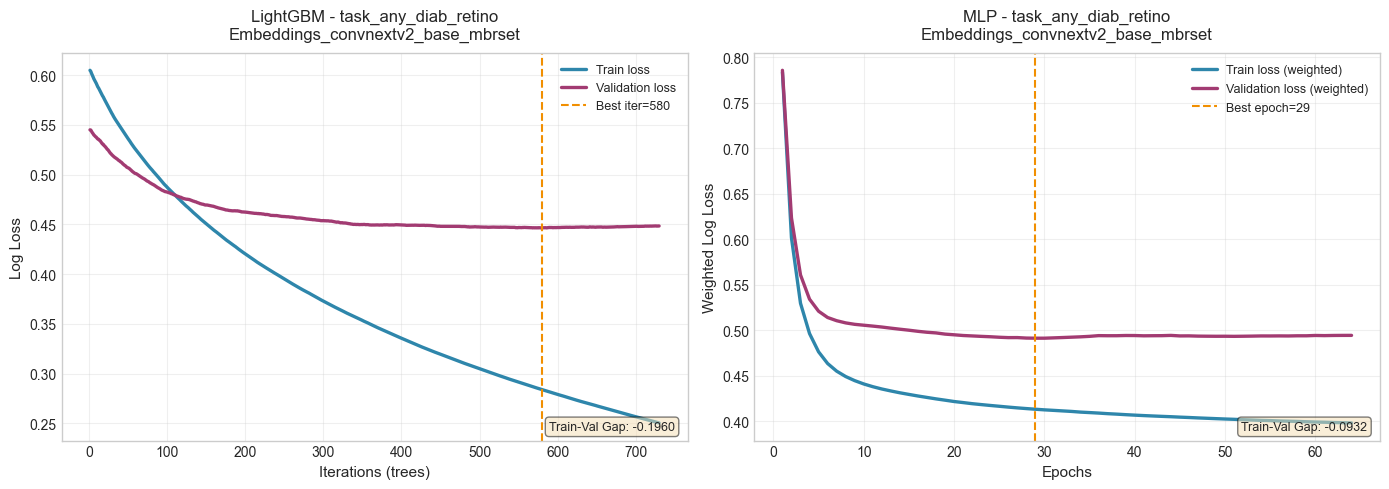


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 881, Stopped at: 1031
    Final train loss: 0.1442, val loss: 0.3307

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 43, Stopped at: 78
    Final train loss: 0.3376, val loss: 0.4193


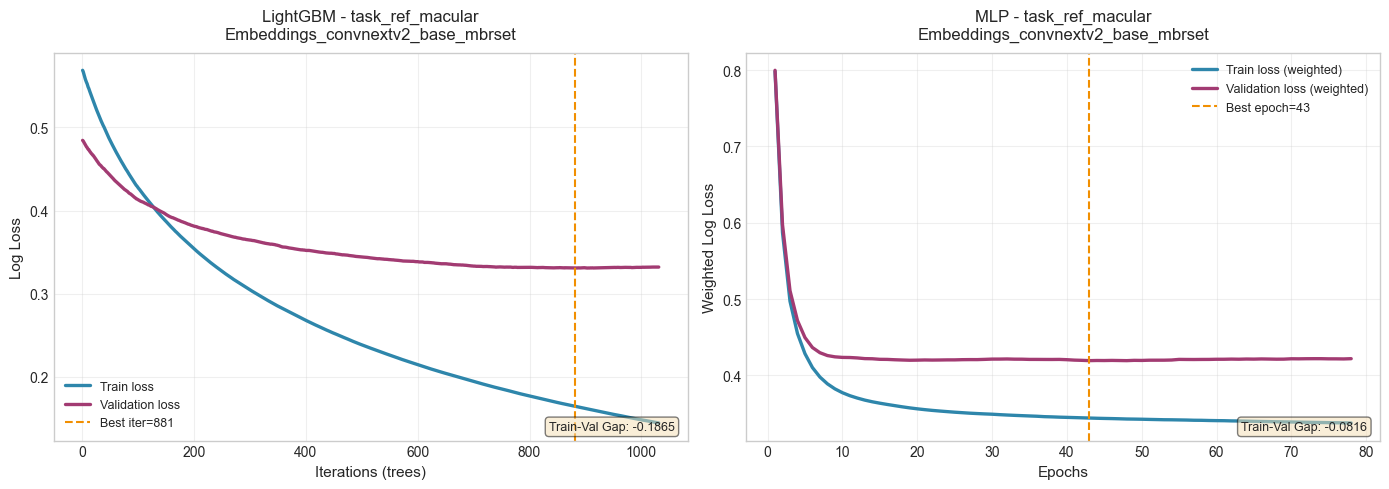


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 801, Stopped at: 951
    Final train loss: 0.1942, val loss: 0.5061

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 81, Stopped at: 121
    Final train loss: 0.5178, val loss: 0.6576


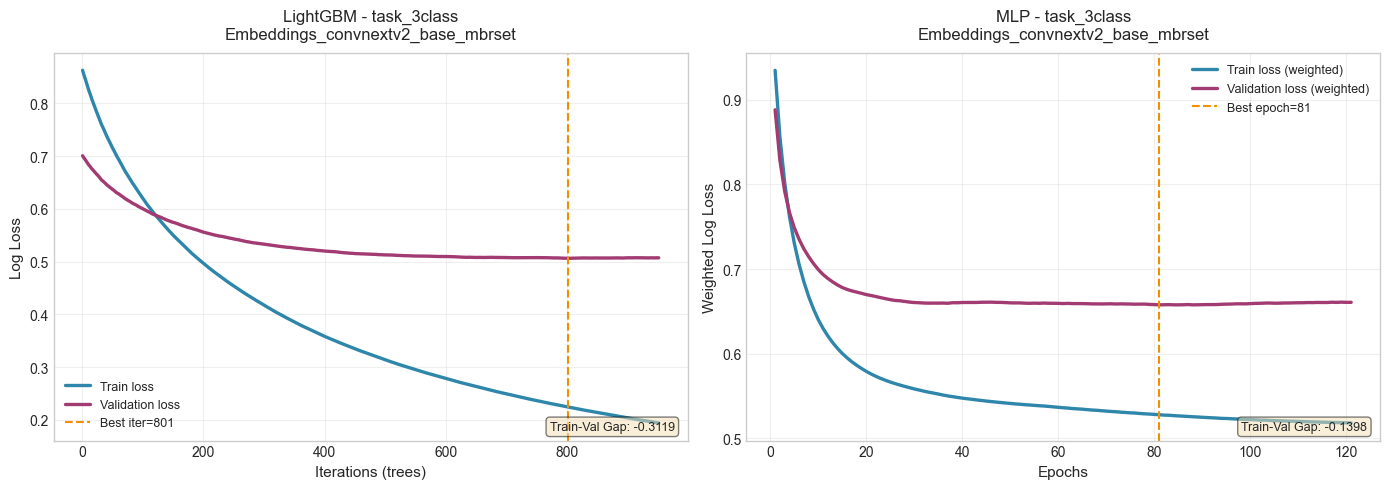


Embedding 2/7: Embeddings_mbrset_dinov3_convnext_base

--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 726, Stopped at: 876
    Final train loss: 0.2509, val loss: 0.4612

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 73, Stopped at: 108
    Final train loss: 0.4384, val loss: 0.5020


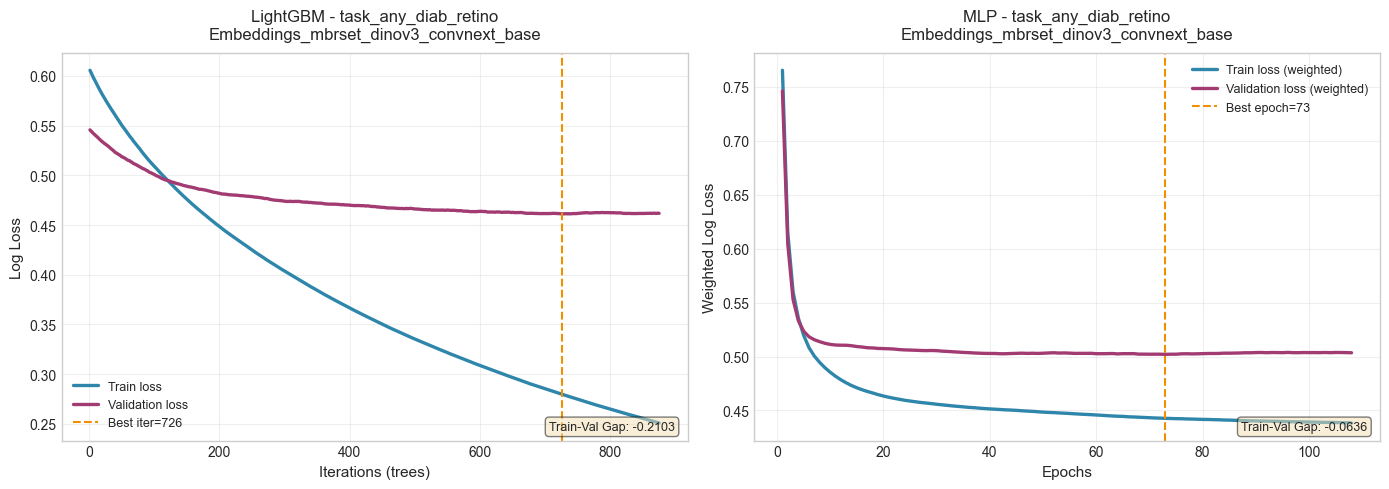


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 820, Stopped at: 970
    Final train loss: 0.1690, val loss: 0.3738

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 94, Stopped at: 129
    Final train loss: 0.3758, val loss: 0.4608


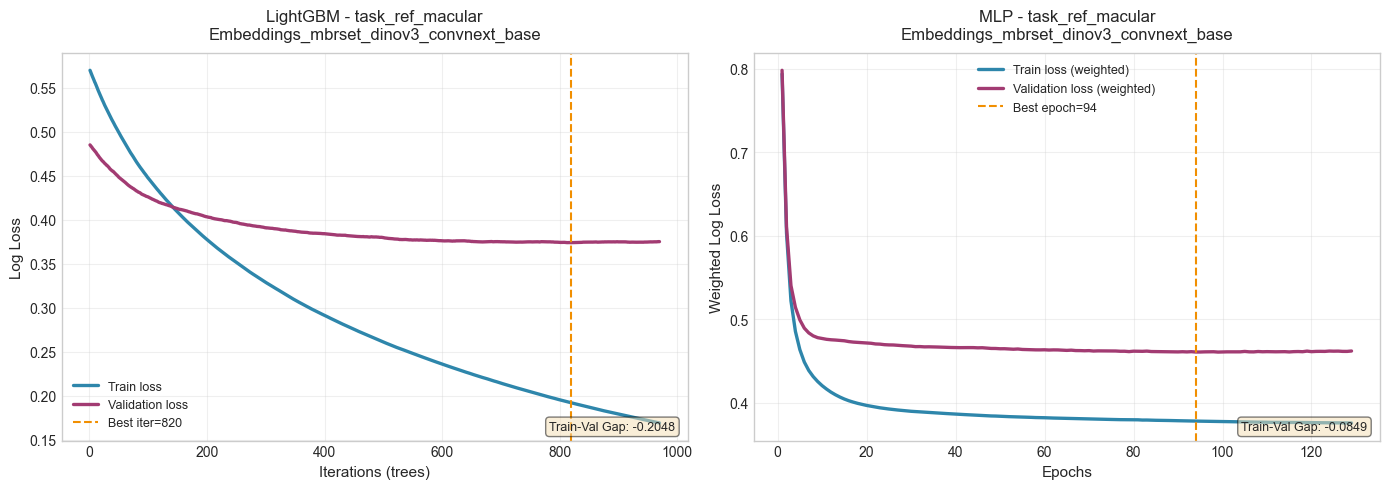


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 485, Stopped at: 635
    Final train loss: 0.2892, val loss: 0.5539

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 75, Stopped at: 115
    Final train loss: 0.5591, val loss: 0.6108


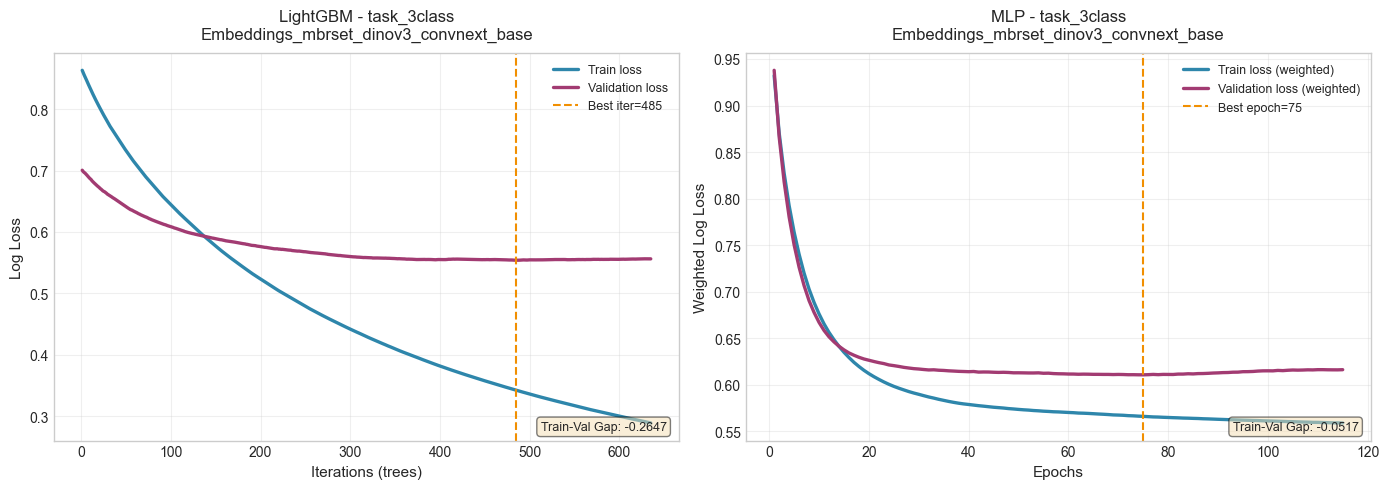


Embedding 3/7: Embeddings_mbrset_dinov3_vitb16

--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 1092, Stopped at: 1242
    Final train loss: 0.1874, val loss: 0.4365

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 29, Stopped at: 64
    Final train loss: 0.4099, val loss: 0.4715


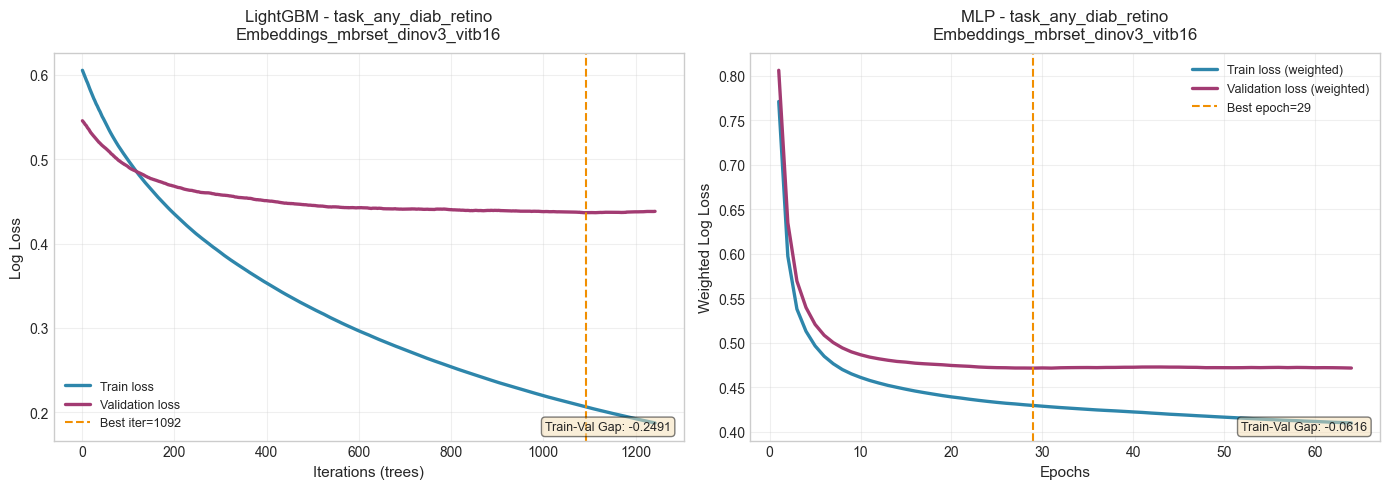


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 667, Stopped at: 817
    Final train loss: 0.1867, val loss: 0.3767

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 35, Stopped at: 70
    Final train loss: 0.3507, val loss: 0.4258


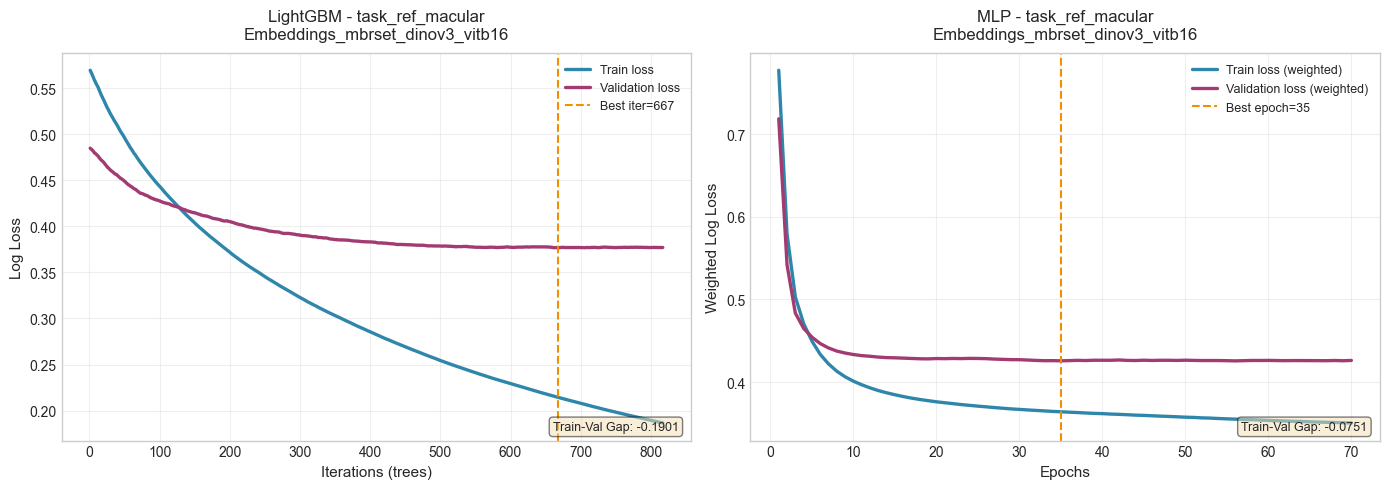


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 652, Stopped at: 802
    Final train loss: 0.2235, val loss: 0.5150

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 102, Stopped at: 142
    Final train loss: 0.4932, val loss: 0.5756


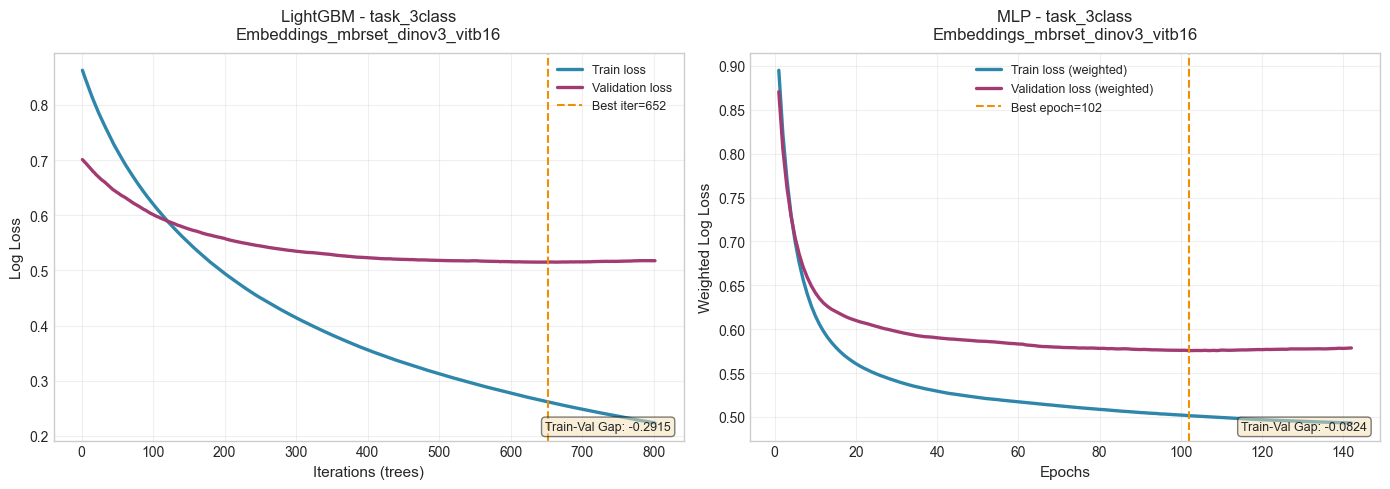


Embedding 4/7: Embeddings_mbrset_RETFound_dinov2_shanghai

--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 1270, Stopped at: 1420
    Final train loss: 0.1690, val loss: 0.4310

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 20, Stopped at: 55
    Final train loss: 0.4176, val loss: 0.4861


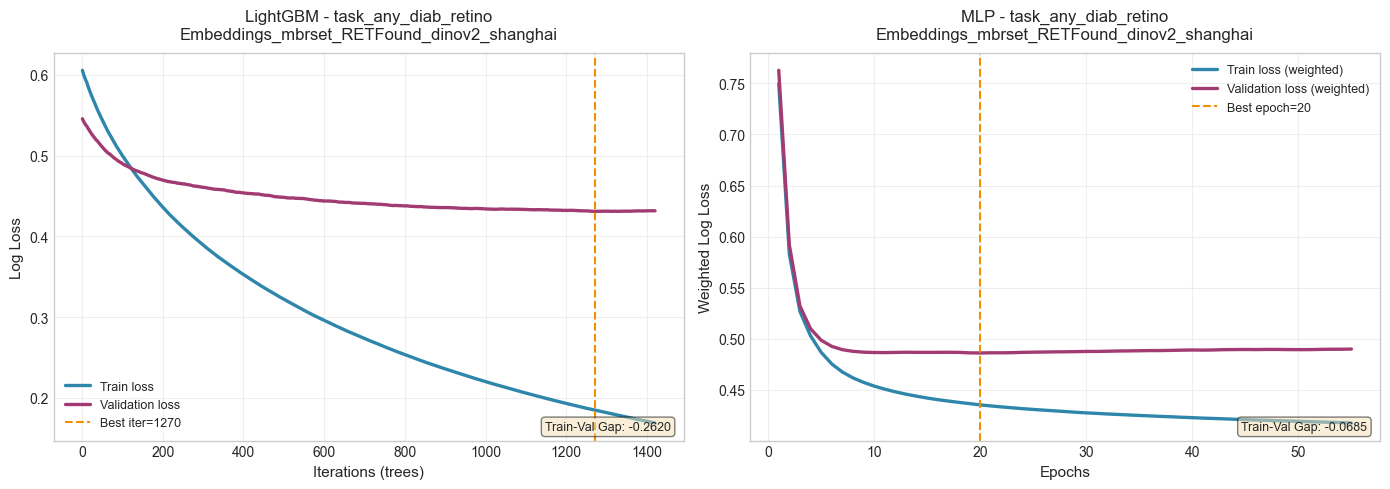


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 805, Stopped at: 955
    Final train loss: 0.1567, val loss: 0.3611

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 34, Stopped at: 69
    Final train loss: 0.3433, val loss: 0.4148


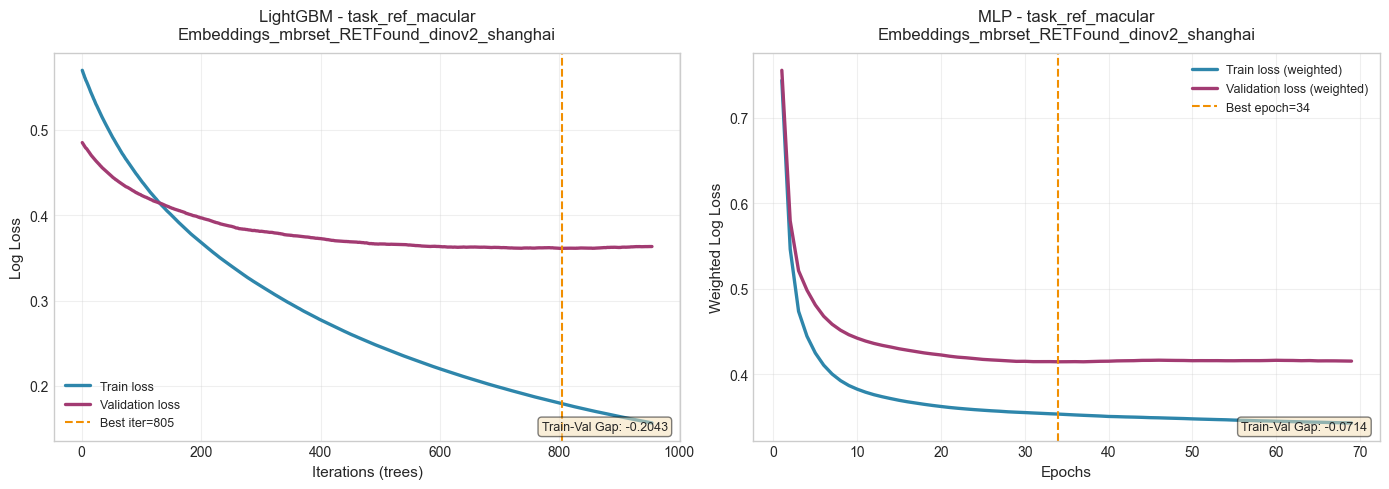


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 664, Stopped at: 814
    Final train loss: 0.2247, val loss: 0.5334

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 206, Stopped at: 246
    Final train loss: 0.4917, val loss: 0.5950


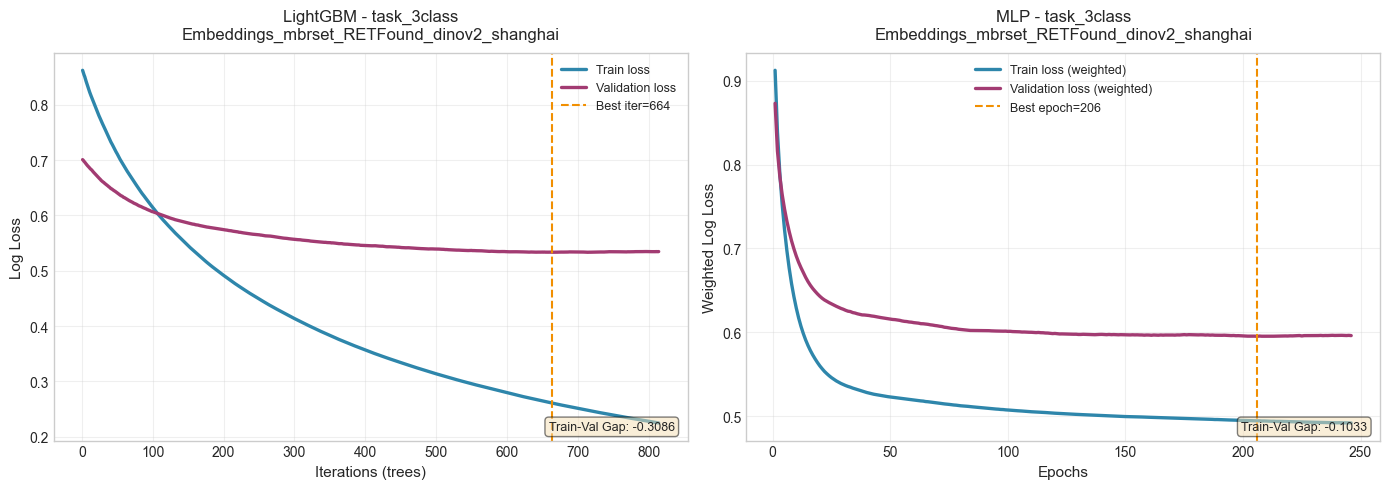


Embedding 5/7: Embeddings_mbrset_RETFound_mae_natureCFP

--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 737, Stopped at: 887
    Final train loss: 0.2768, val loss: 0.4846

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 22, Stopped at: 57
    Final train loss: 0.4809, val loss: 0.5588


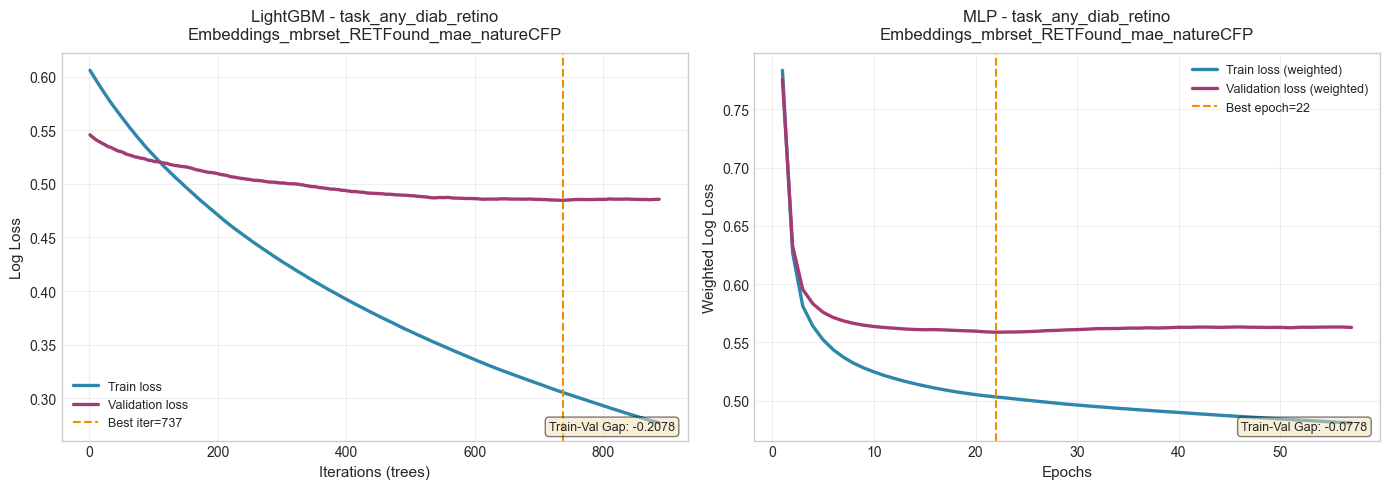


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 1047, Stopped at: 1197
    Final train loss: 0.1740, val loss: 0.4158

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 49, Stopped at: 84
    Final train loss: 0.4277, val loss: 0.4911


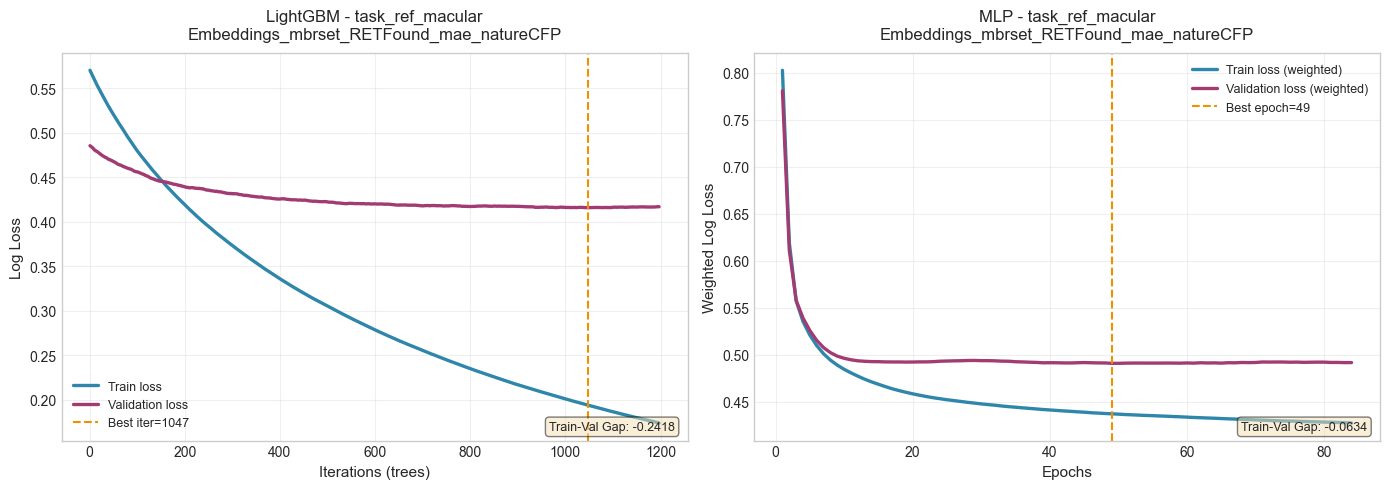


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 1091, Stopped at: 1241
    Final train loss: 0.1966, val loss: 0.5774

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 95, Stopped at: 135
    Final train loss: 0.6329, val loss: 0.7579


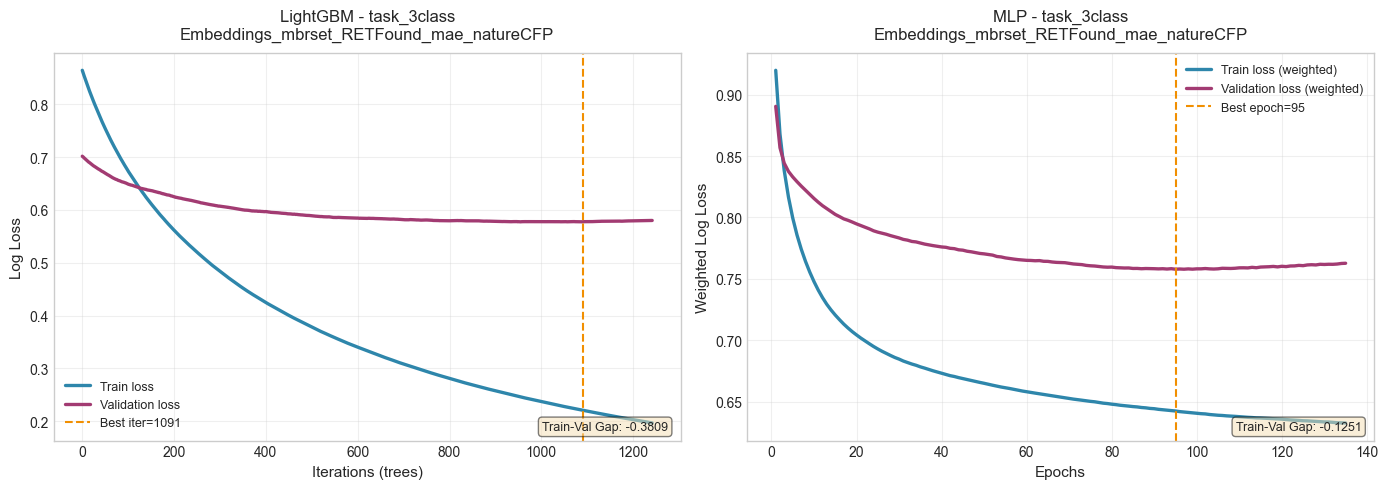


Embedding 6/7: Embeddings_mbrset_RETFound_mae_shanghai

--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 688, Stopped at: 838
    Final train loss: 0.2870, val loss: 0.4912

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 189, Stopped at: 224
    Final train loss: 0.4762, val loss: 0.5529


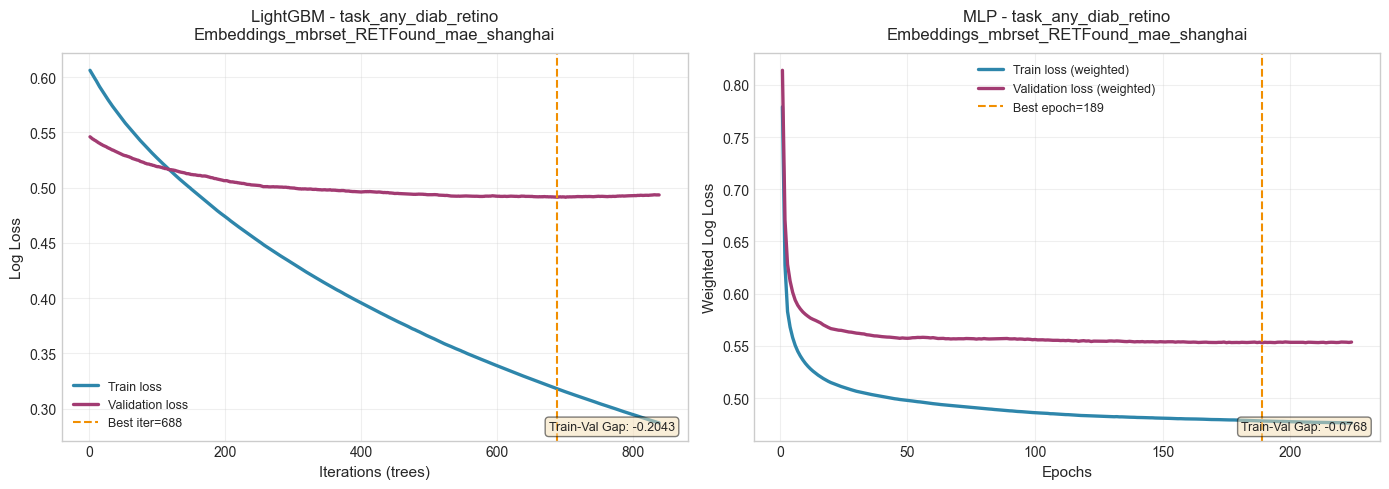


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 621, Stopped at: 771
    Final train loss: 0.2422, val loss: 0.4291

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 94, Stopped at: 129
    Final train loss: 0.4369, val loss: 0.5297


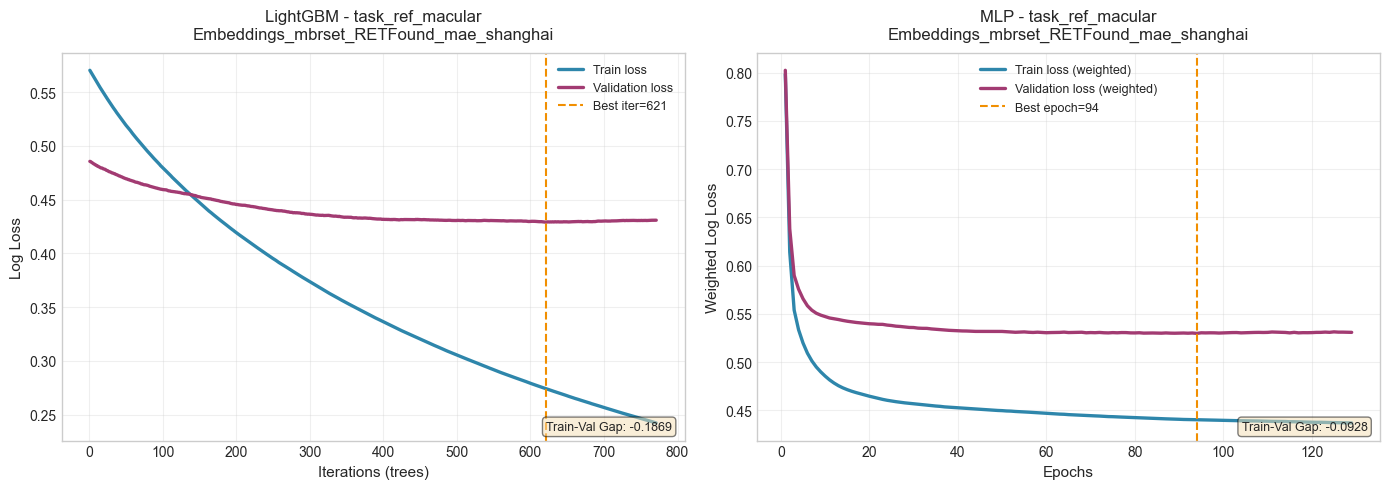


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 388, Stopped at: 538
    Final train loss: 0.3647, val loss: 0.6211

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 16, Stopped at: 56
    Final train loss: 0.6701, val loss: 0.8102


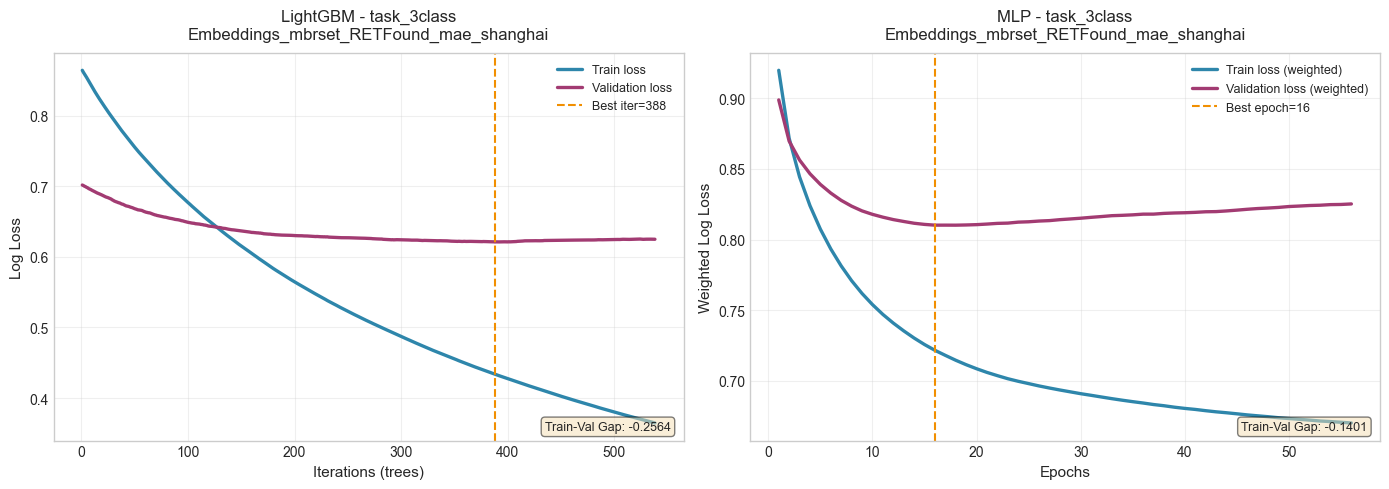


Embedding 7/7: Embeddings_vit_base_mbrset

--- Task: task_any_diab_retino (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 410, Stopped at: 560
    Final train loss: 0.3170, val loss: 0.4802

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 23, Stopped at: 58
    Final train loss: 0.4446, val loss: 0.5132


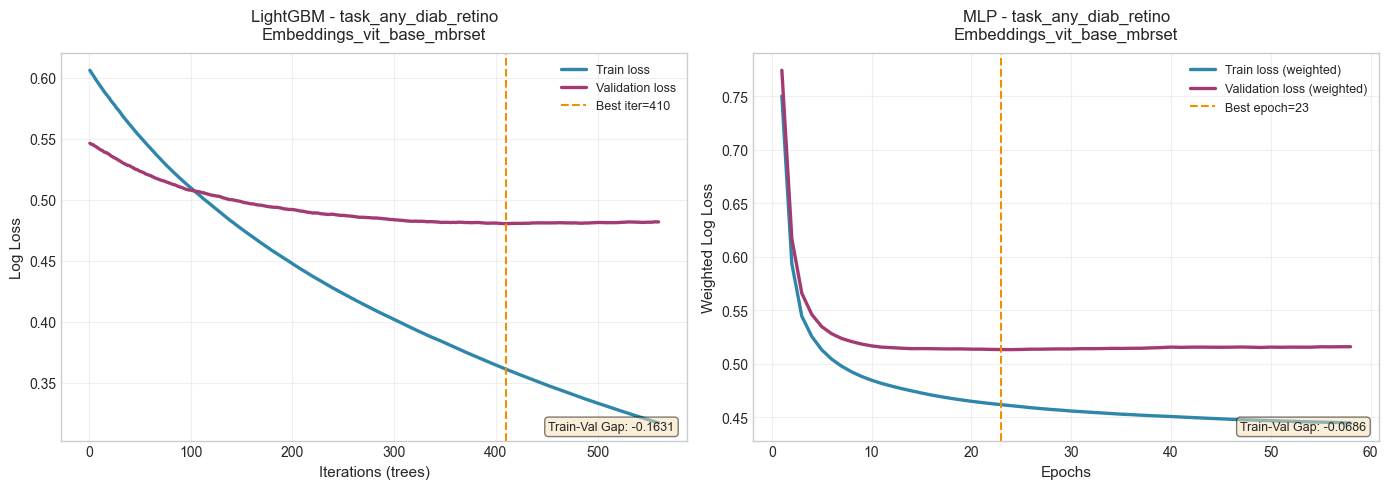


--- Task: task_ref_macular (binary) ---
  Train: 1754 images
  Internal Val: 310 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=15, lr=0.01, reg_lambda=4.5
    Best iteration: 860, Stopped at: 1010
    Final train loss: 0.1731, val loss: 0.3973

  Training MLP with dynamics tracking...
    Config: hidden=(32,), alpha=0.45, lr=0.0008, warmup=5
    Training on original data (1754 samples) with weighted validation
    Best epoch: 29, Stopped at: 64
    Final train loss: 0.3916, val loss: 0.4911


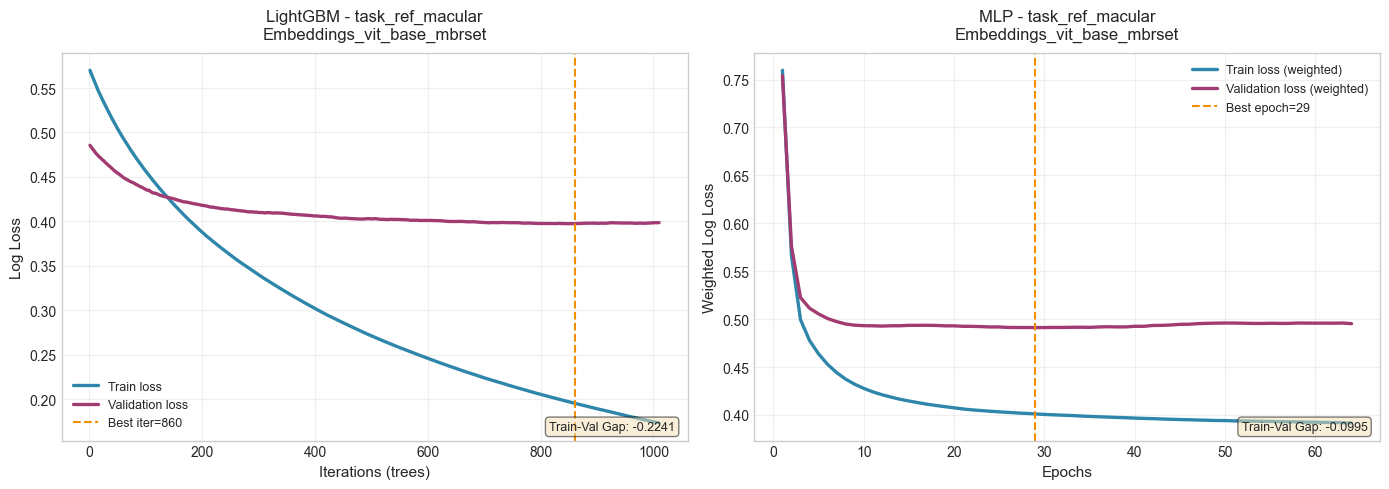


--- Task: task_3class (multiclass) ---
  Train: 1656 images
  Internal Val: 293 images
  Applying PCA (n_components=30)...

  Training LightGBM with dynamics tracking...
    Config: leaves=12, lr=0.01, reg_lambda=3.0
    Best iteration: 629, Stopped at: 779
    Final train loss: 0.2541, val loss: 0.5666

  Training MLP with dynamics tracking...
    Config: hidden=(64,), alpha=0.55, lr=0.0004, warmup=5
    Training on original data (1656 samples) with weighted validation
    Best epoch: 118, Stopped at: 158
    Final train loss: 0.5823, val loss: 0.7067


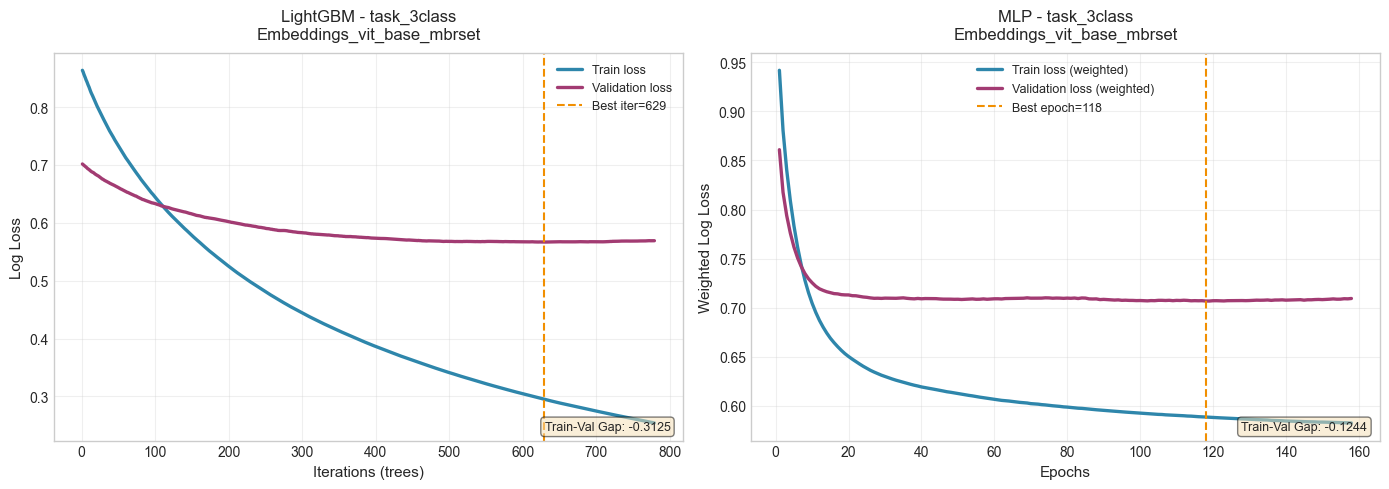


Training dynamics complete!
Plots and CSV files saved to: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\mbrset_patient_eval\training_dynamics


In [22]:
# Training dynamics: track train vs validation loss
# Set to 1 or 2 for faster analysis (or None to run all embeddings)
MAX_EMBEDDINGS_FOR_DYNAMICS = 7
DYNAMICS_DIR = RESULTS_DIR / "training_dynamics"
DYNAMICS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Running training dynamics analysis...")
print(f"Max embeddings: {MAX_EMBEDDINGS_FOR_DYNAMICS if MAX_EMBEDDINGS_FOR_DYNAMICS else 'all'}")

dynamics_embeddings = embedding_files[:MAX_EMBEDDINGS_FOR_DYNAMICS] if MAX_EMBEDDINGS_FOR_DYNAMICS else embedding_files

for emb_idx, emb_path in enumerate(dynamics_embeddings):
    print(f"\n{'='*70}")
    print(f"Embedding {emb_idx+1}/{len(dynamics_embeddings)}: {emb_path.stem}")
    print(f"{'='*70}")
    
    # Load dataset
    ds = load_retina_embeddings_dataset(
        dataset=DATASET_NAME,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=VIEW,
    )
    
    # Apply split
    train_df, test_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")
    
    # Determine available tasks
    tasks = list(BINARY_TASKS)
    if "task_3class" in ds.df.columns:
        tasks.append("task_3class")
    
    for task in tasks:
        if task not in ds.df.columns:
            continue
        
        task_type = "binary" if task in BINARY_TASKS else "multiclass"
        display_task = BINARY_TASK_MAP.get(task, task)
        
        print(f"\n--- Task: {display_task} ({task_type}) ---")
        
        # Prepare data
        train_work = train_df.dropna(subset=[task]).copy()
        
        if train_work.empty:
            print(f"  Skipping {task}: insufficient data")
            continue
        
        X_train_full = train_work.loc[:, ds.feature_cols].to_numpy(dtype=np.float32)
        y_train_full = train_work[task].astype(int).to_numpy()
        
        # Create internal validation split (15% of training data for more stable early stopping)
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.15, random_state=RANDOM_SEED, stratify=y_train_full
        )
        
        print(f"  Train: {len(X_train)} images")
        print(f"  Internal Val: {len(X_val)} images")
        
        # Apply PCA for dynamics analysis (to match main training)
        if USE_PCA:
             print(f"  Applying PCA (n_components={PCA_N_COMPONENTS})...")
             pca_dyn = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_SEED)
             X_train = pca_dyn.fit_transform(X_train)
             X_val = pca_dyn.transform(X_val)
        
        # Resolve per-embedding configs
        lgbm_cfg, lgbm_match = resolve_config("lgbm", task_type, emb_path.stem)
        mlp_cfg, mlp_match = resolve_config("mlp", task_type, emb_path.stem)
        match_name = lgbm_match or mlp_match
        if match_name:
            print(f"  Per-embedding overrides applied (matched: {match_name})")
        
        # --- LGBM Training Dynamics ---
        print(f"\n  Training LightGBM with dynamics tracking...")
        print(f"    Config: leaves={lgbm_cfg['num_leaves']}, lr={lgbm_cfg['learning_rate']}, reg_lambda={lgbm_cfg['reg_lambda']}")
        
        lgbm = LGBMClassifier(
            n_estimators=lgbm_cfg["n_estimators"],
            num_leaves=lgbm_cfg["num_leaves"],
            min_child_samples=lgbm_cfg["min_child_samples"],
            reg_lambda=lgbm_cfg["reg_lambda"],
            reg_alpha=lgbm_cfg["reg_alpha"],
            subsample=lgbm_cfg["subsample"],
            colsample_bytree=lgbm_cfg["colsample_bytree"],
            min_split_gain=lgbm_cfg["min_split_gain"],
            learning_rate=lgbm_cfg["learning_rate"],
            random_state=RANDOM_SEED,
            n_jobs=CPU_COUNT,
            class_weight=lgbm_cfg.get("class_weight", None),
            verbose=-1,
        )
        
        eval_metric = "binary_logloss" if task_type == "binary" else "multi_logloss"
        
        # Calculate manual weights
        train_weights_lgbm = compute_balanced_weights(y_train)

        lgbm.fit(
            X_train, y_train,
            sample_weight=train_weights_lgbm,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_names=["train", "val"],
            eval_metric=eval_metric,
            callbacks=[
                early_stopping(stopping_rounds=150, verbose=False),
                log_evaluation(period=0),
            ],
        )
        
        lgbm_results = lgbm.evals_result_
        lgbm_train_loss = lgbm_results["train"][eval_metric]
        lgbm_val_loss = lgbm_results["val"][eval_metric]
        lgbm_best_iter = int(getattr(lgbm, "best_iteration_", np.argmin(lgbm_val_loss) + 1))
        lgbm_stop_iter = len(lgbm_val_loss)
        
        print(f"    Best iteration: {lgbm_best_iter}, Stopped at: {lgbm_stop_iter}")
        print(f"    Final train loss: {lgbm_train_loss[-1]:.4f}, val loss: {lgbm_val_loss[lgbm_best_iter-1]:.4f}")
        
        # --- MLP Training Dynamics ---
        print(f"\n  Training MLP with dynamics tracking...")
        warmup = mlp_cfg.get("warmup_epochs", 0)
        print(f"    Config: hidden={mlp_cfg['hidden_layer_sizes']}, alpha={mlp_cfg['alpha']}, lr={mlp_cfg['learning_rate_init']}, warmup={warmup}")
        
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_val_s = scaler.transform(X_val)
        
        # Compute balanced sample weights for class-aware validation
        train_weights = compute_balanced_weights(y_train)
        val_weights = compute_balanced_weights(y_val)
        print(f"    Training on original data ({len(y_train)} samples) with weighted validation")
        
        mlp = MLPClassifier(
            hidden_layer_sizes=mlp_cfg["hidden_layer_sizes"],
            alpha=mlp_cfg["alpha"],
            learning_rate_init=mlp_cfg["learning_rate_init"],
            batch_size=mlp_cfg["batch_size"],
            max_iter=1,
            warm_start=True,
            early_stopping=False,
            random_state=RANDOM_SEED,
        )
        
        mlp_train_loss = []
        mlp_val_loss = []
        best_val_loss = float("inf")
        best_epoch = 0
        best_model = None
        patience_counter = 0
        
        labels = np.unique(np.concatenate([y_train, y_val]))
        
        for epoch in range(1, mlp_cfg["max_epochs"] + 1):
            mlp.fit(X_train_s, y_train)
            
            # Compute weighted losses for fair class-aware comparison
            train_proba = mlp.predict_proba(X_train_s)
            val_proba = mlp.predict_proba(X_val_s)
            
            tr_loss = float(weighted_log_loss(y_train, train_proba, labels=labels, sample_weight=train_weights))
            va_loss = float(weighted_log_loss(y_val, val_proba, labels=labels, sample_weight=val_weights))
            
            mlp_train_loss.append(tr_loss)
            mlp_val_loss.append(va_loss)
            
            # Early stopping with warmup — skip patience counting for first N epochs
            if va_loss < best_val_loss - mlp_cfg["min_delta"]:
                best_val_loss = va_loss
                best_epoch = epoch
                best_model = copy.deepcopy(mlp)
                patience_counter = 0
            elif epoch > warmup:
                patience_counter += 1
                if patience_counter >= mlp_cfg["patience"]:
                    break
        
        mlp_stop_epoch = len(mlp_val_loss)
        
        print(f"    Best epoch: {best_epoch}, Stopped at: {mlp_stop_epoch}")
        print(f"    Final train loss: {mlp_train_loss[-1]:.4f}, val loss: {mlp_val_loss[best_epoch-1]:.4f}")
        
        # --- Plot Training Dynamics ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # LGBM plot
        iters = np.arange(1, len(lgbm_train_loss) + 1)
        ax1.plot(iters, lgbm_train_loss, label="Train loss", linewidth=2.4, color="#2E86AB")
        ax1.plot(iters, lgbm_val_loss, label="Validation loss", linewidth=2.4, color="#A23B72")
        ax1.axvline(lgbm_best_iter, linestyle="--", linewidth=1.5, color="#F18F01", 
                    label=f"Best iter={lgbm_best_iter}")
        ax1.set_xlabel("Iterations (trees)", fontsize=11)
        ax1.set_ylabel("Log Loss", fontsize=11)
        ax1.set_title(f"LightGBM - {display_task}\n{emb_path.stem}", fontsize=12, pad=10)
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # Add gap annotation
        final_gap_lgbm = lgbm_train_loss[-1] - lgbm_val_loss[lgbm_best_iter-1]
        ax1.text(0.98, 0.02, f"Train-Val Gap: {final_gap_lgbm:.4f}", 
                 transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
                 horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # MLP plot
        epochs = np.arange(1, len(mlp_train_loss) + 1)
        ax2.plot(epochs, mlp_train_loss, label="Train loss (weighted)", linewidth=2.4, color="#2E86AB")
        ax2.plot(epochs, mlp_val_loss, label="Validation loss (weighted)", linewidth=2.4, color="#A23B72")
        ax2.axvline(best_epoch, linestyle="--", linewidth=1.5, color="#F18F01",
                    label=f"Best epoch={best_epoch}")
        ax2.set_xlabel("Epochs", fontsize=11)
        ax2.set_ylabel("Weighted Log Loss", fontsize=11)
        ax2.set_title(f"MLP - {display_task}\n{emb_path.stem}", fontsize=12, pad=10)
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # Add gap annotation
        final_gap_mlp = mlp_train_loss[-1] - mlp_val_loss[best_epoch-1]
        ax2.text(0.98, 0.02, f"Train-Val Gap: {final_gap_mlp:.4f}", 
                 transform=ax2.transAxes, fontsize=9, verticalalignment='bottom',
                 horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        
        # Save plot
        out_name = f"dynamics_{emb_idx:02d}_{emb_path.stem}_{display_task}.png"
        fig.savefig(DYNAMICS_DIR / out_name, dpi=160, bbox_inches="tight")
        
        if SHOW_PLOTS:
            plt.show()
        else:
            plt.close(fig)
        
        # Save loss curves as CSV
        lgbm_df = pd.DataFrame({
            "iteration": iters,
            "train_loss": lgbm_train_loss,
            "val_loss": lgbm_val_loss,
        })
        lgbm_df.to_csv(DYNAMICS_DIR / f"lgbm_{emb_idx:02d}_{emb_path.stem}_{display_task}.csv", index=False)
        
        mlp_df = pd.DataFrame({
            "epoch": epochs,
            "train_loss": mlp_train_loss,
            "val_loss": mlp_val_loss,
        })
        mlp_df.to_csv(DYNAMICS_DIR / f"mlp_{emb_idx:02d}_{emb_path.stem}_{display_task}.csv", index=False)


print(f"\n{'='*70}")
print(f"Training dynamics complete!")
print(f"Plots and CSV files saved to: {DYNAMICS_DIR}")

## Summary

This notebook performed patient-level evaluation on MBRSET using:
- **Single 80/20 patient split** (reused for all embeddings)
- **Strongly regularized models** to prevent overfitting
- **Patient-level aggregation** (majority vote for predictions, average for probabilities)
- **Comprehensive outputs** (reports, confusion matrices, ROC curves)

All results are saved in the `results/mbrset_patient_eval/` directory.